In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pygsp
import mplleaflet
import scipy as sp

from sklearn.cluster import KMeans

from utils.indexes import days_index, hour_rides, transform_source

In [2]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from networkx.algorithms.community.quality import performance, coverage
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.asyn_fluid import asyn_fluidc


March 1st: first reported case in New York 
<br>
March 4th: Yeshiva University campus closed, high school in the Bronx 
<br>
March 9th 16 confirmed cases 
<br>
March 10th: mitigation measures expanded (online classes for universities) 
<br>
March 11th: CUNY and SUNY closed
<br>
March 14th: first reported death in New York 
<br>
March 16th: NYC public schools closed 
<br>
March 20th: stay-at-home order for non-essential workers, total over 7000 cases
<br>
March 22nd: shortages of PPE for health workers, recommendation that health facilities stop testing non-hospitalized patients
<br>
March 26th: USNS Comfort heading to NYC to assist local hospitals 


New York Weather : MARCH

[weather data](https://www.timeanddate.com/weather/usa/new-york/historic?month=3&year=2020)

In [3]:
df = pd.read_csv('./data/202003-citibike-tripdata.csv')
n_start_station = len(df['start station id'].unique())
n_end_station = len(df['end station id'].unique())


In [4]:
total_station_id = set(df['start station id']).union(set(df['end station id']))
n_tot_station = len(total_station_id)

In [5]:
id_index = dict(zip(sorted(total_station_id), np.arange(n_tot_station)))

In [6]:
df.head()

tripduration                 starttime                  stoptime  \
0          1589  2020-03-01 00:00:03.6400  2020-03-01 00:26:32.9860   
1           389  2020-03-01 00:00:16.7560  2020-03-01 00:06:46.0620   
2           614  2020-03-01 00:00:20.0580  2020-03-01 00:10:34.2200   
3           597  2020-03-01 00:00:24.3510  2020-03-01 00:10:22.3390   
4          1920  2020-03-01 00:00:26.1120  2020-03-01 00:32:26.2680   

   start station id        start station name  start station latitude  \
0               224     Spruce St & Nassau St               40.711464   
1               293     Lafayette St & E 8 St               40.730207   
2               379           W 31 St & 7 Ave               40.749156   
3              3739  Perry St & Greenwich Ave               40.735918   
4               236       St Marks Pl & 2 Ave               40.728419   

   start station longitude  end station id             end station name  \
0               -74.005524            3574  Prospect Pl & Underhill Ave   
1               -73.991026             223              W 13 St & 7 Ave   
2               -73.991600             515             W 43 St & 10 Ave   
3               -74.000939             325              E 19 St & 3 Ave   
4               -73.987140            3124                46 Ave & 5 St   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.676969             -73.965790   16214  Subscriber   
1             40.737815             -73.999947   29994  Subscriber   
2             40.760094             -73.994618   39853  Subscriber   
3             40.736245             -73.984738   42608  Subscriber   
4             40.747310             -73.954510   36288  Subscriber   

   birth year  gender  
0        1980       1  
1        1991       2  
2        1991       1  
3        1989       1  
4        1993       1

# Find Locations #

In [7]:
locations = dict()
for e in id_index.keys():
    if df[df['start station id'] == e]['start station latitude'].shape[0]:
        locations[id_index[e]] = (df[df['start station id'] == e]['start station longitude'].iloc[0],
                                  df[df['start station id'] == e]['start station latitude'].iloc[0])
    else:
        locations[id_index[e]] = (df[df['end station id'] == e]['end station longitude'].iloc[0],
                                  df[df['end station id'] == e]['end station latitude'].iloc[0])
 

# MARCH #

In [8]:
# Dictionary with days starting indexes
"""d = days_index(df)
with open('./data/variables/march_index.pickle', 'wb') as file:
    pickle.dump(d, file)"""


"d = days_index(df)\nwith open('./data/variables/march_index.pickle', 'wb') as file:\n    pickle.dump(d, file)"

In [9]:
# Load day indexes for March
with open('./data/python_variables/march_index.pickle', 'rb') as file:
    d = pickle.load(file)

In [10]:
d_a = [e for e in d.values()]
d_a.append(df.shape[0])
d_a = np.array(d_a)
rides_day = d_a[1:] - d_a[:-1]

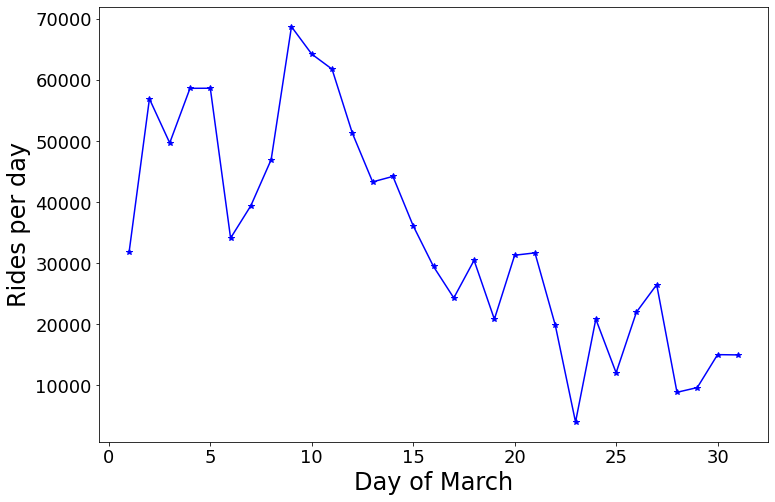

In [11]:
# Rides Per Day
plt.figure(figsize=(12,8))
_ = plt.plot(np.arange(1, 32), rides_day, color='blue', marker='*')
# _ = plt.xticks(np.arange(1, 8), [1, 5, 10, 15, 20, 25, 31], fontsize=18)
_ = plt.xlabel("Day of March", fontsize=24, color='black')
_ = plt.ylabel("Rides per day", fontsize=24, color='black')
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.grid(False)
plt.savefig('./plots/days_aggregated.eps')

In [12]:
print("Maximum number of rides on day {}".format(np.argmax(rides_day)))
print("With {} rides".format(np.max(rides_day)))

Maximum number of rides on day 8
With 68768 rides


In [13]:
# Paramters 
ths = 1

In [14]:
out_nodes = []
for k, v in locations.items():
    if v[0] < -74.02:
        out_nodes.append(k)
out_nodes = set(out_nodes)

## 2st-6th of March ##

In [15]:
# 2 -> Monday
# Choose day 
days = [2, 3, 4, 5, 6]


# Find all connections with weights
adj_2_6_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        
        adj_2_6_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_2_6_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    

Day 2 loaded...
Day 3 loaded...
Day 4 loaded...
Day 5 loaded...
Day 6 loaded...


In [16]:
print("Total number of rides : {}".format(np.sum(adj_2_6_tot) / 2))

Total number of rides : 258160.0


In [17]:
adj_2_6 = adj_2_6_tot.copy()
adj_2_6[adj_2_6 <= ths] = 0
# adj_2_6[adj_2_6 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_2_6) / 2))

for i in range(n_tot_station):
    adj_2_6[i, i] = 0

Unweighted number of rides (edges) : 234391.0


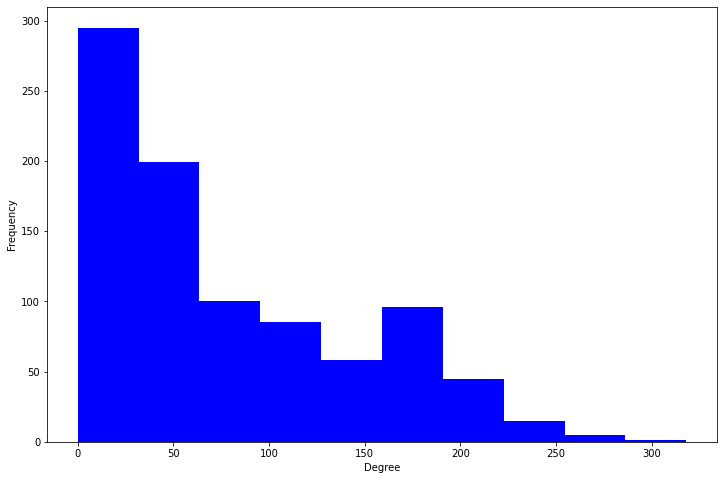

In [18]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_2_6 = nx.from_numpy_matrix(adj_2_6)
g_2_6_tot = nx.from_numpy_matrix(adj_2_6)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_2_6 = np.array([x[1] for x in g_2_6.degree])
_ = plt.hist(degs_2_6, color='blue')
plt.savefig('./plots/degree_2_6.eps')

In [19]:
sp.stats.entropy(np.histogram(degs_2_6, bins=12)[0])

2.013126588901429

## Plot ##

### Clustering ###

In [20]:
isolated_nodes_2_6 = []
for e in nx.connected_components(g_2_6):
    if len(e) < 3:
        isolated_nodes_2_6.append(e.pop())

isolated_nodes_2_6.extend(out_nodes)
isolated_nodes_2_6 = list(set(isolated_nodes_2_6))
g_2_6.remove_nodes_from(isolated_nodes_2_6)

for e in nx.connected_components(g_2_6):
    if len(e) < 3:
        print(e)

In [21]:
G_2_6 = pygsp.graphs.Graph(nx.adjacency_matrix(g_2_6))

G_2_6.compute_laplacian()
G_2_6.compute_fourier_basis()

In [22]:
points = np.array([G_2_6.U[:,1], G_2_6.U[:,2], G_2_6.U[:,2]]).T

In [23]:
km = KMeans(n_clusters=4, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(points)

In [24]:
nx.algorithms.cluster.average_clustering(g_2_6)

0.41782168112512963

In [25]:
"""ks = [3,4,5,6]
metrics = {}
for k in ks:
    metrics[k] = []
    perf = []
    cov  = []
    for i in range(10):
        c_g = list(asyn_fluidc(g_2_6, k))
        perf.append(performance(g_2_6, c_g))
        cov.append(coverage(g_2_6, c_g))
    metrics[k].append(np.array(perf))
    metrics[k].append(np.array(cov))
    
    print("\n")
    
    print("Average Performance with {} clusters : {}".format(k, np.mean(np.array(perf))))
    print("Std on Performance with {} clusters : {}".format(k, np.std(np.array(perf))))
    print("Average Coverage with {} clusters: {}".format(k, np.mean(np.array(cov))))
    print("Std on Coverage with {} clusters: {}".format(k, np.std(np.array(cov))))
"""

'ks = [3,4,5,6]\nmetrics = {}\nfor k in ks:\n    metrics[k] = []\n    perf = []\n    cov  = []\n    for i in range(10):\n        c_g = list(asyn_fluidc(g_2_6, k))\n        perf.append(performance(g_2_6, c_g))\n        cov.append(coverage(g_2_6, c_g))\n    metrics[k].append(np.array(perf))\n    metrics[k].append(np.array(cov))\n    \n    print("\n")\n    \n    print("Average Performance with {} clusters : {}".format(k, np.mean(np.array(perf))))\n    print("Std on Performance with {} clusters : {}".format(k, np.std(np.array(perf))))\n    print("Average Coverage with {} clusters: {}".format(k, np.mean(np.array(cov))))\n    print("Std on Coverage with {} clusters: {}".format(k, np.std(np.array(cov))))\n'

In [26]:
c_g = list(asyn_fluidc(g_2_6, 4))


In [27]:
cols = {}
for i in range(len(c_g)):
    for node in c_g[i]:
        cols[node] = i

l_c = [cols[e] for e in sorted(list(cols.keys()))]

In [28]:
import matplotlib

In [29]:
cmap = matplotlib.cm.get_cmap('hot')

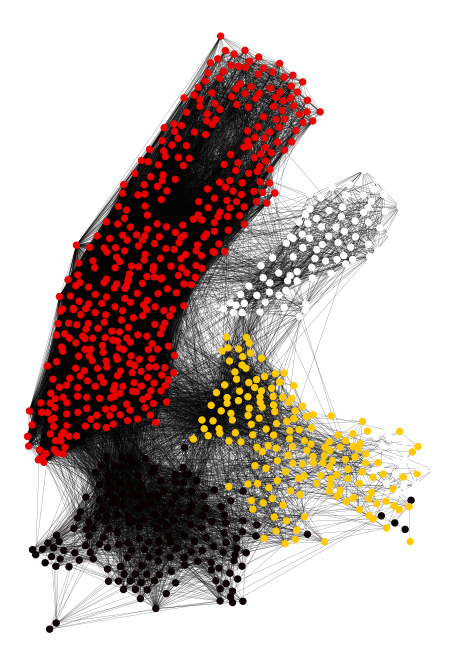

In [30]:
plt.figure(figsize=(8,12))

nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=l_c, cmap=cmap)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

## 9th-13th of March ##

In [31]:
ov = 0
ov2 = 0
for k,v in locations.items():
    if v[0] < locations[ov][0]:
        ov2 = ov
        ov = k     
    elif v[0] < locations[ov2][0]:
        ov2 = k

In [32]:
# 9 -> Monday
# Choose day 
days = [9, 10, 11, 12, 13]

# Find all connections with weights
adj_9_13_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_9_13_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_9_13_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 9 loaded...
Day 10 loaded...
Day 11 loaded...
Day 12 loaded...
Day 13 loaded...


In [33]:
print("Total number of rides : {}".format(np.sum(adj_9_13_tot) / 2))

Total number of rides : 289536.0


In [34]:
adj_9_13 = adj_9_13_tot.copy()
adj_9_13[adj_9_13 <= ths] = 0
# adj_9_13[adj_9_13 >= ths] = 1

print("Unweighted number of rides : {}".format(np.sum(adj_9_13) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_9_13[i, i] = 0

Unweighted number of rides : 260814.0


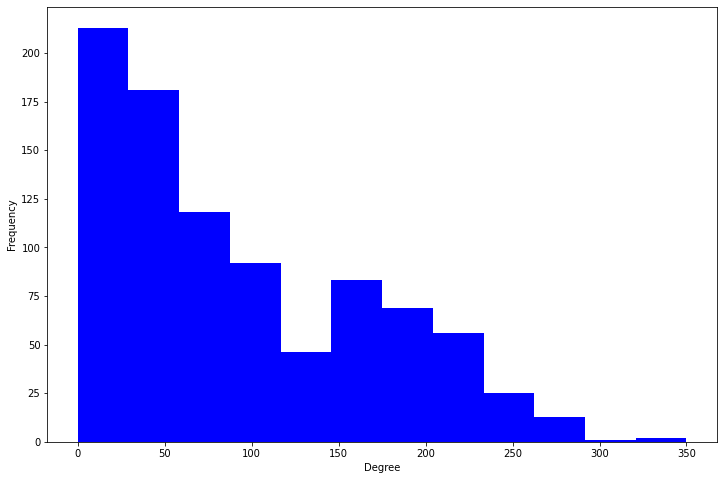

In [35]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_9_13 = nx.from_numpy_matrix(adj_9_13)
g_9_13_tot = nx.from_numpy_matrix(adj_9_13)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_9_13 = np.array([x[1] for x in g_9_13.degree])
_ = plt.hist(degs_9_13, bins=12, color='blue')
plt.savefig('./plots/degree_9_13.eps')

In [36]:
sp.stats.entropy(np.histogram(degs_9_13, bins=12)[0])

2.0877286645667237

In [37]:
print(nx.average_clustering(g_9_13))

0.4238727831833754


## Plot Clusters ##

In [38]:
isolated_nodes_9_13 = []
for e in nx.connected_components(g_9_13):
    if len(e) < 3:
        isolated_nodes_9_13.append(e.pop())

isolated_nodes_9_13.extend(out_nodes)
isolated_nodes_9_13 = list(set(isolated_nodes_9_13))
g_9_13.remove_nodes_from(isolated_nodes_9_13)

for e in nx.connected_components(g_9_13):
    if len(e) < 3:
        print(e)

In [39]:
G_9_13 = pygsp.graphs.Graph(nx.adjacency_matrix(g_9_13))

G_9_13.compute_laplacian()
G_9_13.compute_fourier_basis()

In [40]:
"""means_9_perf = []
std_9_perf = []

means_9_cov = []
std_9_cov = []

ks = [3,4,5,6]
metrics = {}
for k in ks:
    metrics[k] = []
    perf = []
    cov  = []
    for i in range(10):
        c_g = list(asyn_fluidc(g_9_13, k))
        p = performance(g_9_13, c_g)
        perf.append(p)
        c = coverage(g_9_13, c_g)
        cov.append(c)
       
        print("\n")

        print("Performance with {} clusters : {}".format(k,p))
        print("Coverage with {} clusters: {}".format(k,c))
    print("\n")
"""

'means_9_perf = []\nstd_9_perf = []\n\nmeans_9_cov = []\nstd_9_cov = []\n\nks = [3,4,5,6]\nmetrics = {}\nfor k in ks:\n    metrics[k] = []\n    perf = []\n    cov  = []\n    for i in range(10):\n        c_g = list(asyn_fluidc(g_9_13, k))\n        p = performance(g_9_13, c_g)\n        perf.append(p)\n        c = coverage(g_9_13, c_g)\n        cov.append(c)\n       \n        print("\n")\n\n        print("Performance with {} clusters : {}".format(k,p))\n        print("Coverage with {} clusters: {}".format(k,c))\n    print("\n")\n'

In [41]:
c_g = list(asyn_fluidc(g_9_13, 4))


In [42]:
cols = {}
for i in range(len(c_g)):
    for node in c_g[i]:
        cols[node] = i

l_c = [cols[e] for e in sorted(list(cols.keys()))]

In [43]:
color_cluster = ['yellow', 'blue', 'red', 'gray', 'green']
vec_col = [color_cluster[e] for e in l_c]

In [44]:
plt.figure(figsize=(8, 12))

nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=vec_col)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

plt.savefig('plots/cluster_5_9_trade.jpeg')

mplleaflet.show()

## 16th-20th of March ##

In [45]:
# 16 -> Monday
# Choose day 
days = [16, 17, 18, 19, 20]

# Find all connections with weights
adj_16_20_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_16_20_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_16_20_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 16 loaded...
Day 17 loaded...
Day 18 loaded...
Day 19 loaded...
Day 20 loaded...


In [46]:
print("Total number of rides : {}".format(np.sum(adj_16_20_tot) / 2))

Total number of rides : 136477.0


In [47]:
adj_16_20 = adj_16_20_tot.copy()
adj_16_20[adj_16_20 <= ths] = 0
"""adj_16_20[adj_16_20 >= ths] = 1"""

print("Unweighted number of rides : {}".format(np.sum(adj_16_20) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_16_20[i, i] = 0

Unweighted number of rides : 113508.0


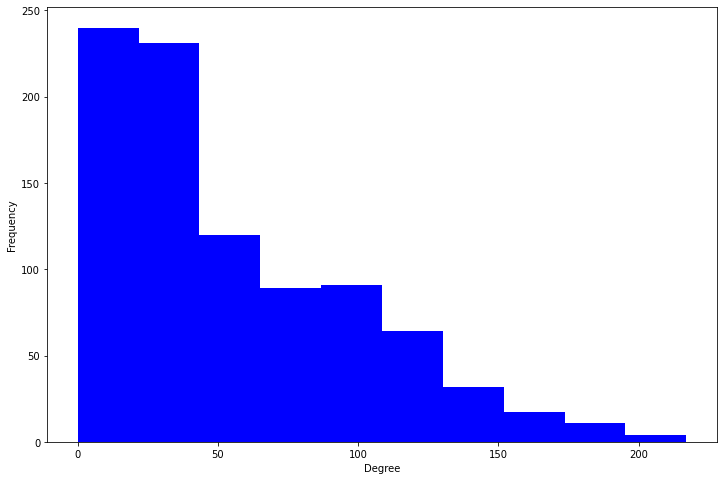

In [48]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_16_20 = nx.from_numpy_matrix(adj_16_20)
g_16_20_tot = nx.from_numpy_matrix(adj_16_20)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_16_20 = np.array([x[1] for x in g_16_20.degree])
_ = plt.hist(degs_16_20, color='blue')
plt.savefig('./plots/degree_16_20.eps')

## Plot Clusters ## 

In [49]:
isolated_nodes_16_20 = []
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        isolated_nodes_16_20.append(e.pop())
isolated_nodes_16_20.extend(out_nodes)
isolated_nodes_16_20 = list(set(isolated_nodes_16_20))
g_16_20.remove_nodes_from(isolated_nodes_16_20)

for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        print(e)

In [50]:
isolated_nodes_16_20_ = []
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        isolated_nodes_16_20_.append(e.pop())
isolated_nodes_16_20 = list(set(isolated_nodes_16_20))
g_16_20.remove_nodes_from(isolated_nodes_16_20_)

In [51]:
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        print(e)

In [52]:
isolated_nodes_16_20.extend(isolated_nodes_16_20_)
isolated_nodes_16_20 = list(set(isolated_nodes_16_20))

In [53]:
G_16_20 = pygsp.graphs.Graph(nx.adjacency_matrix(g_16_20))

G_16_20.compute_laplacian()
G_16_20.compute_fourier_basis()

In [54]:
"""means_16_perf = []
std_16_perf = []

means_16_cov = []
std_16_cov = []

ks = [3,4,5,6]
metrics = {}
for k in ks:
    metrics[k] = []
    perf = []
    cov  = []
    for i in range(10):
        c_g = list(asyn_fluidc(g_16_20, k))
        perf.append(performance(g_16_20, c_g))
        cov.append(coverage(g_16_20, c_g))
    metrics[k].append(np.array(perf))
    metrics[k].append(np.array(cov))
    
    means_16_perf.append(np.mean(np.array(perf)))
    std_16_perf.append(np.std(np.array(perf)))
    means_16_cov.append(np.mean(np.array(cov)))
    std_16_cov.append(np.std(np.array(cov)))
    
    
    print("\n")
    
    print("Average Performance with {} clusters : {}".format(k,np.mean(np.array(perf) )))
    print("Std on Performance with {} clusters : {}".format(k, np.std(np.array(perf))))
    print("Average Coverage with {} clusters: {}".format(k, np.mean(np.array(cov))))
    print("Std on Coverage with {} clusters: {}".format(k, np.std(np.array(cov))))
"""

'means_16_perf = []\nstd_16_perf = []\n\nmeans_16_cov = []\nstd_16_cov = []\n\nks = [3,4,5,6]\nmetrics = {}\nfor k in ks:\n    metrics[k] = []\n    perf = []\n    cov  = []\n    for i in range(10):\n        c_g = list(asyn_fluidc(g_16_20, k))\n        perf.append(performance(g_16_20, c_g))\n        cov.append(coverage(g_16_20, c_g))\n    metrics[k].append(np.array(perf))\n    metrics[k].append(np.array(cov))\n    \n    means_16_perf.append(np.mean(np.array(perf)))\n    std_16_perf.append(np.std(np.array(perf)))\n    means_16_cov.append(np.mean(np.array(cov)))\n    std_16_cov.append(np.std(np.array(cov)))\n    \n    \n    print("\n")\n    \n    print("Average Performance with {} clusters : {}".format(k,np.mean(np.array(perf) )))\n    print("Std on Performance with {} clusters : {}".format(k, np.std(np.array(perf))))\n    print("Average Coverage with {} clusters: {}".format(k, np.mean(np.array(cov))))\n    print("Std on Coverage with {} clusters: {}".format(k, np.std(np.array(cov))))\n'

In [55]:
c_g = list(asyn_fluidc(g_16_20, 4))

In [56]:
print(g_16_20.number_of_nodes())

882


In [57]:
cols = {}
for i in range(len(c_g)):
    for node in c_g[i]:
        cols[node] = i

l_c = [cols[e] for e in sorted(list(cols.keys()))]

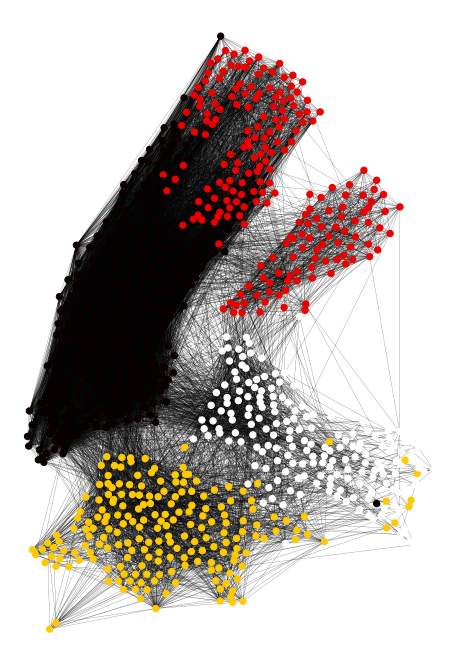

In [58]:
plt.figure(figsize=(8,12))

nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=l_c, cmap=cmap)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

In [59]:
nx.algorithms.cluster.average_clustering(g_16_20)

0.3106690590812846

In [60]:
sp.stats.entropy(np.histogram(degs_16_20, bins=12)[0])

2.071667170595518

## 23st-29th of March ##

In [61]:
# 23 -> Monday
# Choose day 
days = [23, 24, 25, 26, 27]


# Find all connections with weights
adj_23_27_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_23_27_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_23_27_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 23 loaded...
Day 24 loaded...
Day 25 loaded...
Day 26 loaded...
Day 27 loaded...


In [62]:
print("Total number of rides : {}".format(np.sum(adj_23_27_tot) / 2))

Total number of rides : 85428.0


In [63]:
adj_23_27 = adj_23_27_tot.copy()
adj_23_27[adj_23_27 <= ths] = 0
"""adj_23_27[adj_23_27 >= ths] = 1"""
print("Unweighted number of rides : {}".format(np.sum(adj_23_27) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_23_27[i, i] = 0

Unweighted number of rides : 67368.0


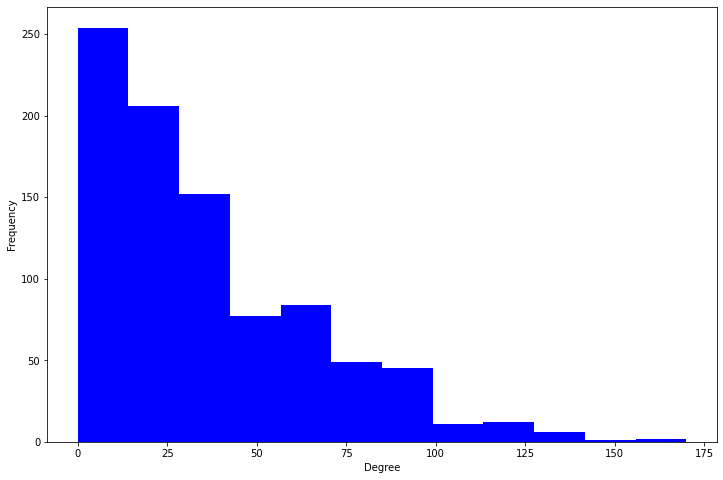

In [64]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_23_27 = nx.from_numpy_matrix(adj_23_27)
g_23_27_tot = nx.from_numpy_matrix(adj_23_27)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_23_27 = np.array([x[1] for x in g_23_27.degree])
_ = plt.hist(degs_23_27, bins=12, color='blue')
plt.savefig('./plots/degree_23_29.eps')

In [65]:
sp.stats.entropy(np.histogram(degs_23_27, bins=12)[0])

1.9017853170418322

In [66]:
print(nx.average_clustering(g_23_27))

0.24215186567936373


## Plot Clusters ##

In [67]:
isolated_nodes_23_27 = []
for e in nx.connected_components(g_23_27):
    if len(e) < 3:
        isolated_nodes_23_27.append(e.pop())

isolated_nodes_23_27.extend(out_nodes)
isolated_nodes_23_27 = list(set(isolated_nodes_23_27))
g_23_27.remove_nodes_from(isolated_nodes_23_27)

for e in nx.connected_components(g_23_27):
    if len(e) < 3:
        print(e)

In [68]:
G_23_27 = pygsp.graphs.Graph(nx.adjacency_matrix(g_23_27))

G_23_27.compute_laplacian()
G_23_27.compute_fourier_basis()

In [69]:
"""max_23_perf = []
max_23_cov = []



ks = [3, 4,5,6]
metrics = {}
for k in ks:
    metrics[k] = []
    perf = []
    cov  = []
    for i in range(10):
        c_g = list(asyn_fluidc(g_23_27, k))
        p = performance(g_23_27, c_g)
        perf.append(p)
        c = coverage(g_23_27, c_g)
        cov.append(c)
        print("\n")

        print("Performance with {} clusters : {}".format(k,p))
        print("Coverage with {} clusters: {}".format(k, c))
        
    print("\n")
"""

'max_23_perf = []\nmax_23_cov = []\n\n\n\nks = [3, 4,5,6]\nmetrics = {}\nfor k in ks:\n    metrics[k] = []\n    perf = []\n    cov  = []\n    for i in range(10):\n        c_g = list(asyn_fluidc(g_23_27, k))\n        p = performance(g_23_27, c_g)\n        perf.append(p)\n        c = coverage(g_23_27, c_g)\n        cov.append(c)\n        print("\n")\n\n        print("Performance with {} clusters : {}".format(k,p))\n        print("Coverage with {} clusters: {}".format(k, c))\n        \n    print("\n")\n'

In [70]:
c_g = list(asyn_fluidc(g_23_27, 5))

In [71]:
cols = {}
for i in range(len(c_g)):
    for node in c_g[i]:
        cols[node] = i

l_c = [cols[e] for e in sorted(list(cols.keys()))]

In [72]:

print(performance(g_23_27, c_g))
print(coverage(g_23_27, c_g))

0.8079949346367378
0.7951159196290571


In [73]:
color_cluster = ['yellow', 'blue', 'red', 'gray', 'green']
vec_col = [color_cluster[e] for e in l_c]

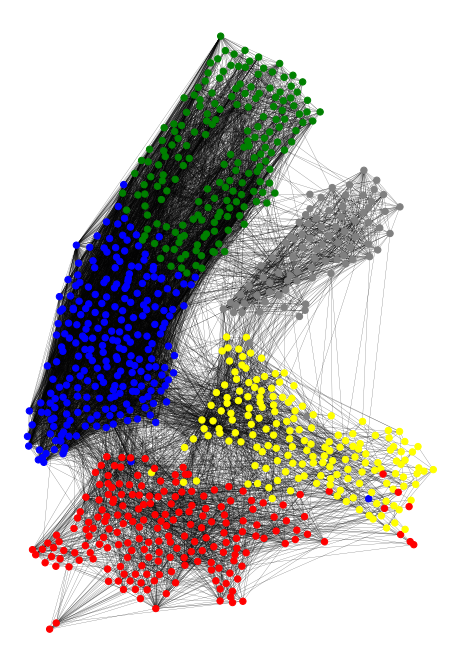

In [74]:
plt.figure(figsize=(8, 12))

nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=vec_col)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

plt.savefig('plots/cluster_5_23_best.jpeg')

In [75]:
upper_man_idx = c_g[2]
queens_idx = c_g[4]

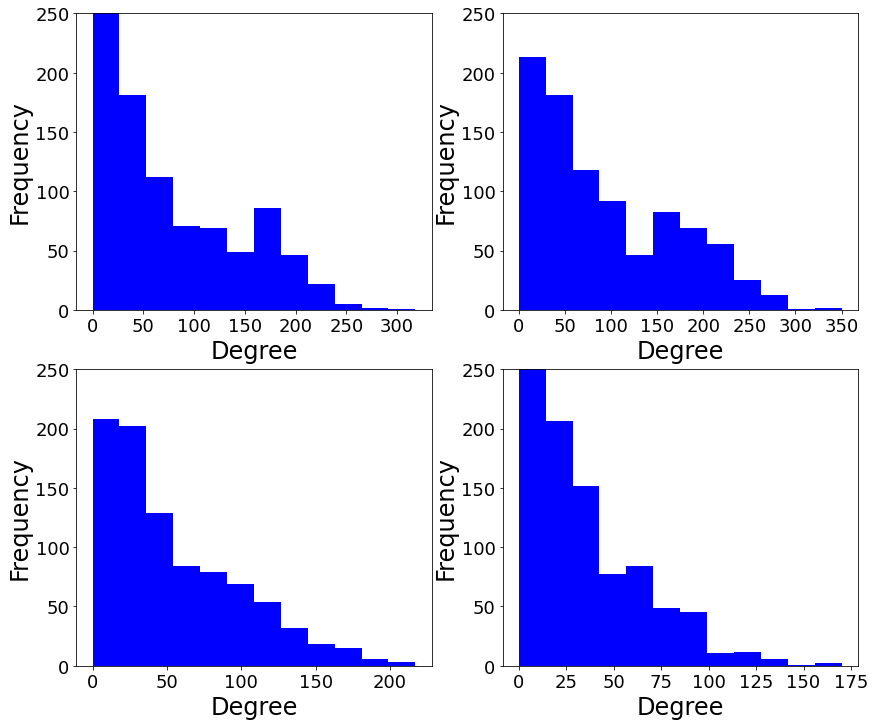

In [76]:
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
plt.xlabel('Degree', fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.grid(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 250)
_ = plt.hist(degs_2_6, bins=12, color='blue')

plt.subplot(2,2,2)
plt.xlabel('Degree', fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.grid(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 250)
_ = plt.hist(degs_9_13, bins=12, color='blue')

plt.subplot(2,2,3)
plt.xlabel('Degree', fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.grid(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 250)
_ = plt.hist(degs_16_20, bins=12, color='blue')

plt.subplot(2,2,4)
plt.xlabel('Degree', fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.grid(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 250)
_ = plt.hist(degs_23_27, bins=12, color='blue')

plt.savefig('plots/degs_hist.eps')

## Deg-Sorted Nodes over time ##

In [77]:
sort_deg = np.argsort(degs_2_6)

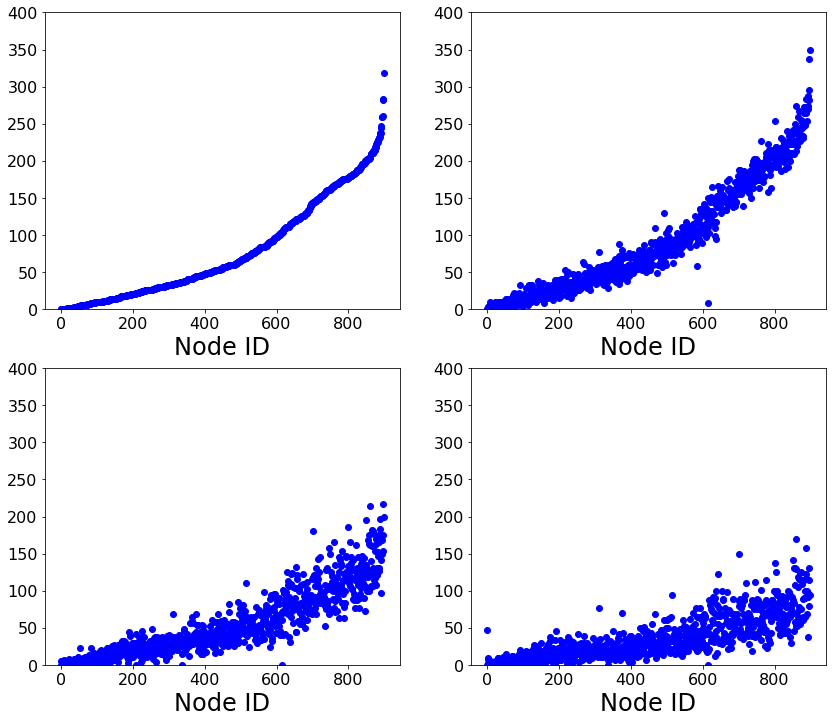

In [78]:
plt.figure(figsize=(14, 12))

plt.subplot(2,2,1)
plt.scatter(np.arange(n_tot_station), degs_2_6[sort_deg], color='blue')
plt.xlabel('Node ID', fontsize=24)
# plt.ylabel('Week 1 Degree', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,400)
plt.grid(False)

plt.subplot(2,2,2)
plt.scatter(np.arange(n_tot_station), degs_9_13[sort_deg], color='blue')
plt.xlabel('Node ID', fontsize=24)
# plt.ylabel('Week 2 Degree', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,400)
plt.grid(False)

plt.subplot(2,2,3)
plt.scatter(np.arange(n_tot_station), degs_16_20[sort_deg], color='blue')
plt.xlabel('Node ID', fontsize=24)
# plt.ylabel('Week 3 Degree', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,400)
plt.grid(False)

plt.subplot(2,2,4)
plt.scatter(np.arange(n_tot_station), degs_23_27[sort_deg], color='blue')
plt.xlabel('Node ID', fontsize=24)
# plt.ylabel('Week 4 Degree', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,400)
plt.grid(False)

plt.savefig('./plots/degree_ordered.eps')

# Functions on Graphs #

In [214]:
f_2_6 = np.sum(adj_2_6_tot, axis=0)
f_9_13 = np.sum(adj_9_13_tot, axis=0)
f_16_20 = np.sum(adj_16_20_tot, axis=0)
f_23_27 = np.sum(adj_23_27_tot, axis=0)

rif = f_2_6 + 1

r_2_6 = rif / rif
r_9_13 = f_9_13 / rif
r_16_20 = f_16_20 / rif
r_23_27 = f_23_27 / rif

rif = degs_2_6 + 1

d_2_6 = rif / rif
d_9_13 = degs_9_13 / rif
d_16_20 = degs_16_20 / rif
d_23_37 = degs_23_27 / rif

f_2_6 = np.delete(f_2_6, isolated_nodes_2_6)
f_9_13 = np.delete(f_9_13, isolated_nodes_9_13)
f_16_20 = np.delete(f_16_20, isolated_nodes_16_20)
f_23_27 = np.delete(f_23_27, isolated_nodes_23_27)

r_2_6 = np.delete(r_2_6, isolated_nodes_2_6)
r_9_13 = np.delete(r_9_13, isolated_nodes_9_13)
r_16_20 = np.delete(r_16_20, isolated_nodes_16_20)
r_23_27 = np.delete(r_23_27, isolated_nodes_23_27)

d_2_6 = np.delete(d_2_6, isolated_nodes_2_6)
d_9_13 = np.delete(d_9_13, isolated_nodes_9_13)
d_16_20 = np.delete(d_16_20, isolated_nodes_16_20)
d_23_27 = np.delete(d_23_37, isolated_nodes_23_27)

In [80]:
f_2_6.shape

(881,)

In [81]:
cmap = plt.cm.get_cmap('jet')

# Graph over means

In [82]:
m_2_6 = f_2_6 / np.mean(f_2_6)
m_9_13 = f_9_13 / np.mean(f_9_13)
m_16_20 = f_16_20 / np.mean(f_16_20)
m_23_27 = f_23_27 / np.mean(f_23_27)

In [83]:
cmap= matplotlib.cm.get_cmap('jet')

In [84]:
print(np.mean(f_2_6))
print(np.mean(f_9_13))
print(np.mean(f_16_20))
print(np.mean(f_23_27))

586.0011350737798
653.5541760722348
309.45691609977325
193.6859410430839


In [85]:
print(np.max(m_2_6))
print(np.max(m_9_13))
print(np.max(m_16_20))
print(np.max(m_23_27))

8.672338150608116
7.537248143075974
5.7164661959910745
6.587984616375248


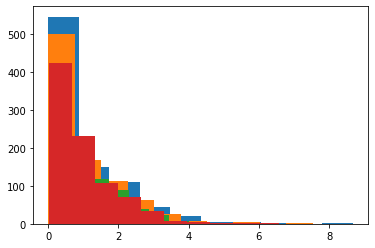

In [86]:
_ = plt.hist(m_2_6)
_ = plt.hist(m_9_13)
_ = plt.hist(m_16_20)
_ = plt.hist(m_23_27)

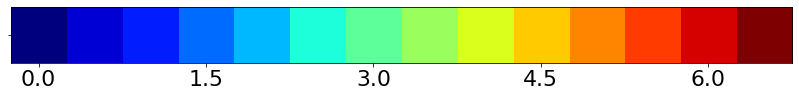

In [87]:
plt.figure(figsize=(14,15))
mat = np.arange(0, 7, 0.5)
label = np.array([round(x, 2) for x in mat])
mat = np.expand_dims(mat, axis=0)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')

plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], label[[0, 3, 6, 9, 12]], fontsize=22)
plt.set_cmap(cmap=cmap)

plt.savefig('plots/means_cmap.jpeg')

In [202]:
cmap= matplotlib.cm.get_cmap('jet')
plt.figure(figsize=(10,18))
plt.subplot(2,2,1)

plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_2_6, locations, node_size=80, node_color=m_2_6, cmap=cmap, vmin=0, vmax=7)
# nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

mplleaflet.show()

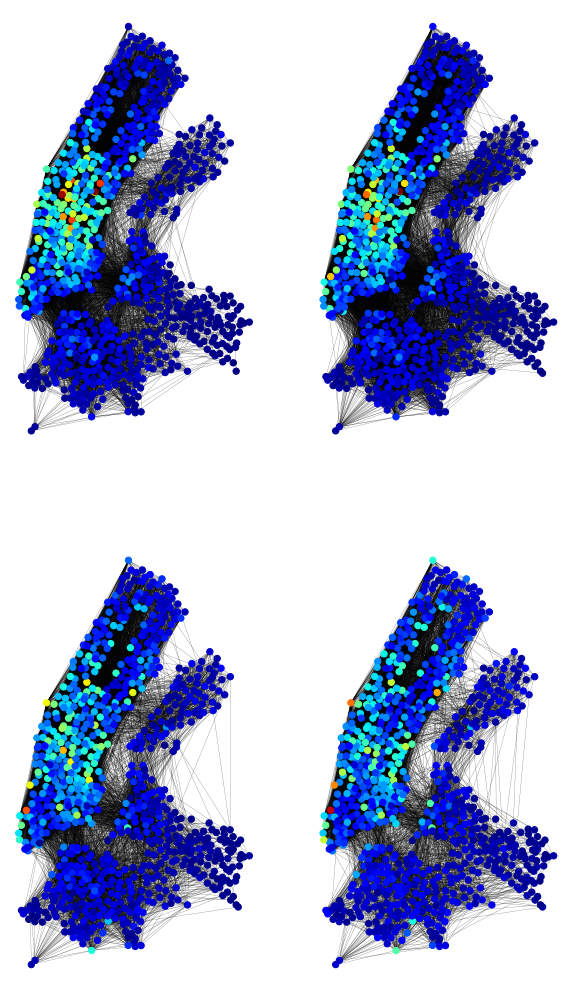

In [88]:
plt.figure(figsize=(10,18))
plt.subplot(2,2,1)

plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=m_2_6, cmap=cmap, vmin=0, vmax=7)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=m_9_13, cmap=cmap, vmin=0, vmax=7)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=m_16_20, cmap=cmap, vmin=0, vmax=7)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=m_23_27, cmap=cmap, vmin=0, vmax=7)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

plt.savefig('plots/over_means.jpeg')

In [189]:
rev = dict(zip(list(id_index.values()), list(id_index.keys())))


In [195]:
df[df['start station id'] == rev[117]]

tripduration                 starttime                  stoptime  \
165               292  2020-03-01 00:20:02.6310  2020-03-01 00:24:54.9380   
4427              382  2020-03-01 10:32:08.5320  2020-03-01 10:38:31.1000   
6612              360  2020-03-01 11:33:12.0730  2020-03-01 11:39:12.7500   
6996             1155  2020-03-01 11:42:37.6510  2020-03-01 12:01:52.7810   
7024               76  2020-03-01 11:43:25.0760  2020-03-01 11:44:41.6750   
...               ...                       ...                       ...   
1066802           756  2020-03-31 19:37:28.7130  2020-03-31 19:50:05.0380   
1067242            97  2020-03-31 20:10:06.2260  2020-03-31 20:11:44.1390   
1067301          1458  2020-03-31 20:15:07.6200  2020-03-31 20:39:25.8880   
1067881          1399  2020-03-31 21:26:09.0170  2020-03-31 21:49:28.6270   
1067882          1392  2020-03-31 21:26:12.4840  2020-03-31 21:49:25.3700   

         start station id  start station name  start station latitude  \
165                   359  E 47 St & Park Ave               40.755103   
4427                  359  E 47 St & Park Ave               40.755103   
6612                  359  E 47 St & Park Ave               40.755103   
6996                  359  E 47 St & Park Ave               40.755103   
7024                  359  E 47 St & Park Ave               40.755103   
...                   ...                 ...                     ...   
1066802               359  E 47 St & Park Ave               40.755103   
1067242               359  E 47 St & Park Ave               40.755103   
1067301               359  E 47 St & Park Ave               40.755103   
1067881               359  E 47 St & Park Ave               40.755103   
1067882               359  E 47 St & Park Ave               40.755103   

         start station longitude  end station id  \
165                   -73.974987             173   
4427                  -73.974987            2021   
6612                  -73.974987            3687   
6996                  -73.974987            3151   
7024                  -73.974987             359   
...                          ...             ...   
1066802               -73.974987            3156   
1067242               -73.974987             164   
1067301               -73.974987            3374   
1067881               -73.974987            3325   
1067882               -73.974987            3325   

                                      end station name  end station latitude  \
165                                 Broadway & W 49 St             40.760683   
4427                                   W 45 St & 8 Ave             40.759291   
6612                                   E 33 St & 1 Ave             40.743227   
6996                                E 81 St & York Ave             40.772838   
7024                                E 47 St & Park Ave             40.755103   
...                                                ...                   ...   
1066802                             E 72 St & York Ave             40.766638   
1067242                                E 47 St & 2 Ave             40.753231   
1067301  Central Park North & Adam Clayton Powell Blvd             40.799484   
1067881                                E 95 St & 3 Ave             40.784903   
1067882                                E 95 St & 3 Ave             40.784903   

         end station longitude  bikeid    usertype  birth year  gender  
165                 -73.984527   28326  Subscriber        1988       1  
4427                -73.988597   39952  Subscriber        1981       1  
6612                -73.974498   36555  Subscriber        1994       1  
6996                -73.949892   32988  Subscriber        1990       1  
7024                -73.974987   18737    Customer        1987       1  
...                        ...     ...         ...         ...     ...  
1066802             -73.953483   35257  Subscriber        1976       1  
1067242             -73.970325   4155

In [89]:
cmap= matplotlib.cm.get_cmap('jet')

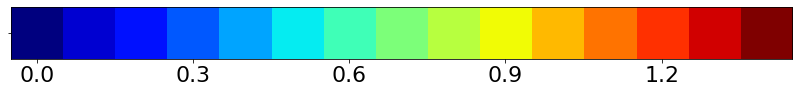

In [90]:
plt.figure(figsize=(14,15))
mat = np.arange(0, 1.5, 0.1)
label = np.array([round(x, 2) for x in mat])
mat = np.expand_dims(mat, axis=0)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')

plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], label[[0, 3, 6, 9, 12]], fontsize=22)
plt.set_cmap(cmap=cmap)

plt.savefig('plots/relative_cmap.jpeg')

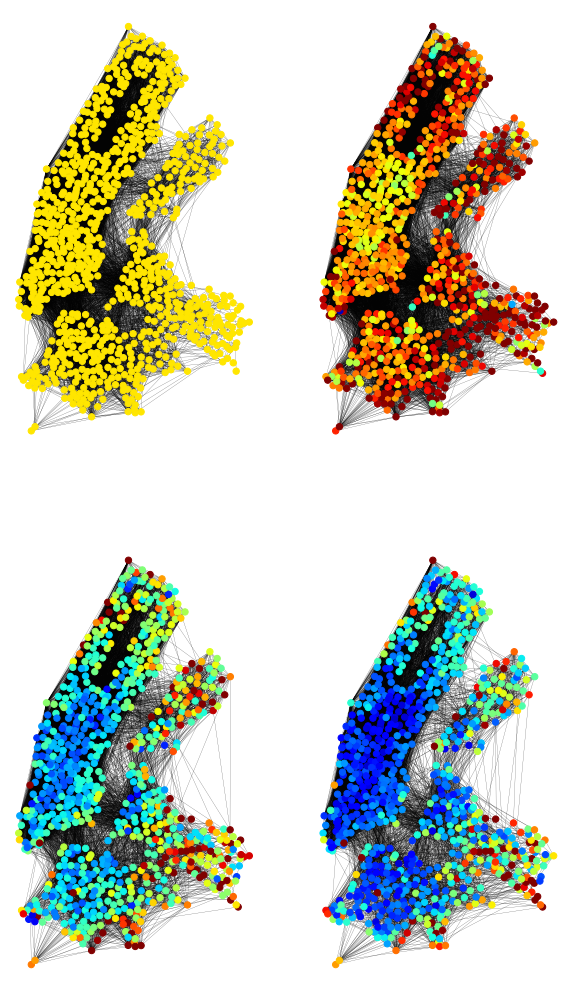

In [91]:
plt.figure(figsize=(10,18))
plt.subplot(2,2,1)

plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=r_2_6, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=r_9_13, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=r_16_20, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=r_23_27, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

plt.savefig('plots/ratio_first_week.jpeg')

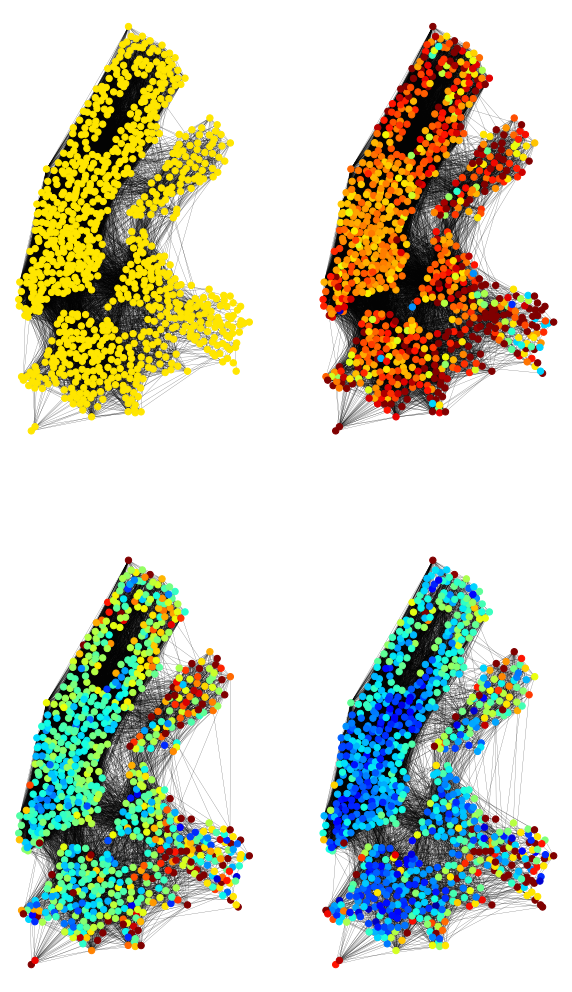

In [218]:
plt.figure(figsize=(10,18))
plt.subplot(2,2,1)

plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=d_2_6, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=d_9_13, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=d_16_20, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=d_23_27, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

plt.savefig('plots/ratio_deg_first_week.jpeg')

# 1) Temporal Analysis # 

## Weekly days #

In [93]:
# First Week 
hour_full_2_8 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [2, 3, 4, 5, 6, 7, 8]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_2_8.extend(h_rides)
    # plt.plot(h_rides)
    j += 1
    1

In [94]:
# Second Week
hour_full_9_15 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [9, 10, 11, 12, 13, 14, 15]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_9_15.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [95]:
# Third Week
hour_full_16_22 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [16, 17, 18, 19, 20, 21, 22]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_16_22.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [96]:
# Fourth Week
hour_full_23_29 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [23, 24, 25, 26, 27, 28, 29]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_23_29.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [97]:
full_month = []
full_month.extend(hour_full_2_8)
full_month.extend(hour_full_9_15)
full_month.extend(hour_full_16_22)
full_month.extend(hour_full_23_29)

In [209]:
# rain = [[24,30],[36,42], [108,114],[114,120],[270,276],[366,372],[408,414],[414,420],[510,516],[516,520],[564,570], [630, 636]]
weekend = [[120, 167], [287,335], [455, 503], [623, 671]]

In [210]:
with open('./data/python_variables/weekedns.pickle', 'wb') as file:
    pickle.dump(weekend, file)

In [ ]:
plt.figure(figsize=(24,12))
_ = plt.plot(full_month, color='black')
_ = plt.plot(np.arange(120, 167), hour_full_2_8[120:], color='green')
_ = plt.plot(np.arange(287, 335), hour_full_9_15[120:], color='green')
_ = plt.plot(np.arange(455, 503), hour_full_16_22[120:], color='green')
_ = plt.plot(np.arange(623, 671), hour_full_23_29[120:], color='green')


_ = plt.plot(np.arange(24, 30), full_month[24:30], color='blue')
_ = plt.plot(np.arange(36, 42), full_month[36:42], color='blue')
_ = plt.plot(np.arange(108, 114), full_month[108:114], color='blue')
_ = plt.plot(np.arange(114, 120), full_month[114:120], color='blue')
_ = plt.plot(np.arange(270, 276), full_month[270:276], color='blue')
_ = plt.plot(np.arange(366, 372), full_month[366:372], color='blue')
_ = plt.plot(np.arange(408, 414), full_month[408:414], color='blue')
_ = plt.plot(np.arange(414, 420), full_month[414:420], color='blue')
_ = plt.plot(np.arange(510, 516), full_month[510:516], color='blue')
_ = plt.plot(np.arange(516, 520), full_month[516:520], color='blue')
_ = plt.plot(np.arange(564, 570), full_month[564:570], color='blue')
_ = plt.plot(np.arange(630, 636), full_month[630:636], color='blue')


_ = plt.xticks([0, 167, 335, 503], np.arange(1, 5), fontsize=18)

_ = plt.xlabel('Hours', fontsize=24)
_ = plt.ylabel('# of Rides', fontsize=24)
_ = plt.yticks(fontsize=18)
plt.grid(False)
plt.savefig('./plots/hours_rides.eps')

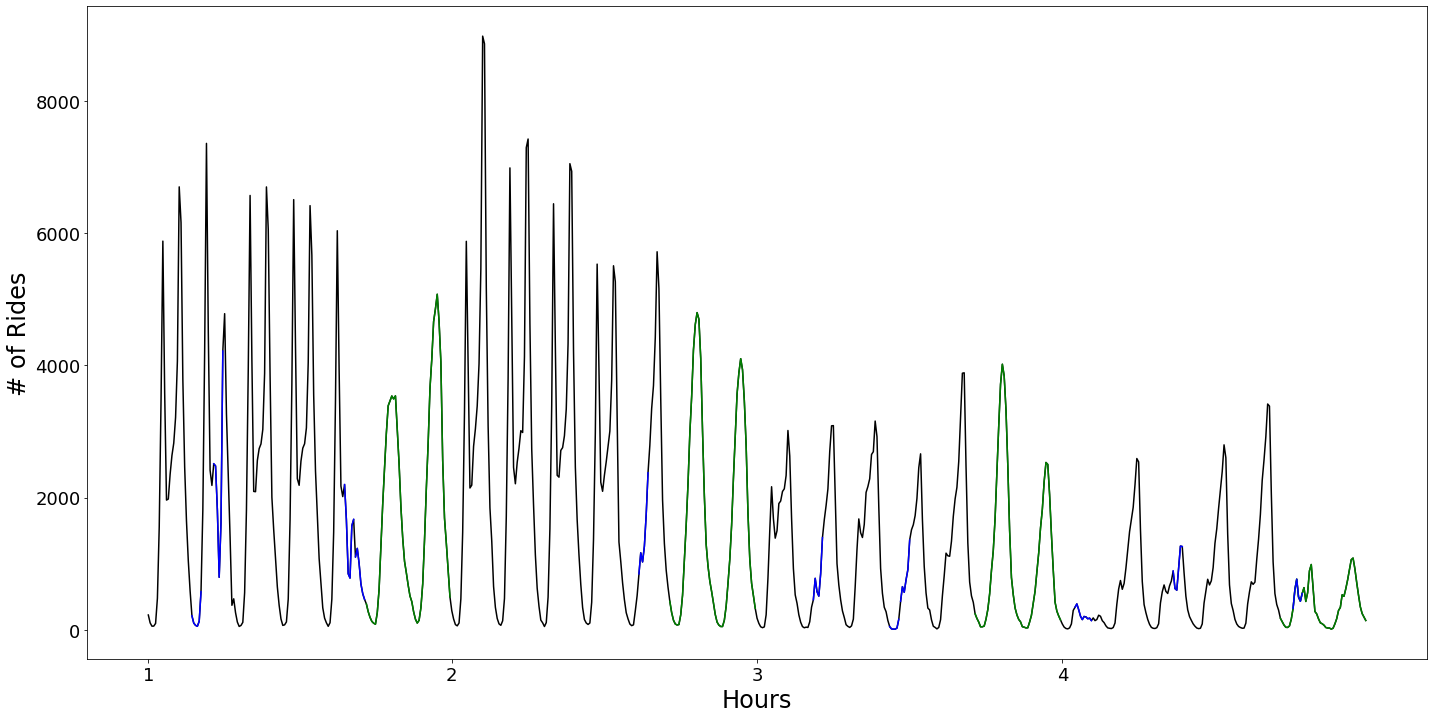

In [98]:
plt.figure(figsize=(24,12))
_ = plt.plot(full_month, color='black')
_ = plt.plot(np.arange(120, 167), hour_full_2_8[120:], color='green')
_ = plt.plot(np.arange(287, 335), hour_full_9_15[120:], color='green')
_ = plt.plot(np.arange(455, 503), hour_full_16_22[120:], color='green')
_ = plt.plot(np.arange(623, 671), hour_full_23_29[120:], color='green')


_ = plt.plot(np.arange(24, 30), full_month[24:30], color='blue')
_ = plt.plot(np.arange(36, 42), full_month[36:42], color='blue')
_ = plt.plot(np.arange(108, 114), full_month[108:114], color='blue')
_ = plt.plot(np.arange(114, 120), full_month[114:120], color='blue')
_ = plt.plot(np.arange(270, 276), full_month[270:276], color='blue')
_ = plt.plot(np.arange(366, 372), full_month[366:372], color='blue')
_ = plt.plot(np.arange(408, 414), full_month[408:414], color='blue')
_ = plt.plot(np.arange(414, 420), full_month[414:420], color='blue')
_ = plt.plot(np.arange(510, 516), full_month[510:516], color='blue')
_ = plt.plot(np.arange(516, 520), full_month[516:520], color='blue')
_ = plt.plot(np.arange(564, 570), full_month[564:570], color='blue')
_ = plt.plot(np.arange(630, 636), full_month[630:636], color='blue')


_ = plt.xticks([0, 167, 335, 503], np.arange(1, 5), fontsize=18)

_ = plt.xlabel('Hours', fontsize=24)
_ = plt.ylabel('# of Rides', fontsize=24)
_ = plt.yticks(fontsize=18)
plt.grid(False)
plt.savefig('./plots/hours_rides.eps')

# Trip Duration #

In [99]:
# Set last day
d[32] = -1

In [100]:
td = []
days = np.arange(1, 32)
out = []
for day in days:
    ti = []
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        if row['tripduration'] < 3600:
            ti.append(row['tripduration'] )
        else:
            out.append(row['tripduration'])
    td.append(ti)

    

In [101]:
m = []
for e in td:
    e = np.array(e)
    m.append(np.mean(e))
    

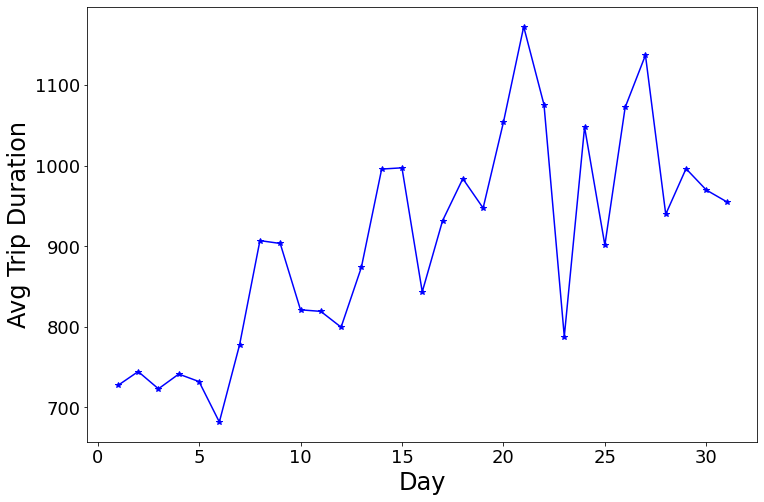

In [102]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(1, 32), m, color='blue', marker='*')
# _ = plt.xticks(np.arange(1, 32), np.arange(1, 32))
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.xlabel('Day', fontsize=24)
plt.ylabel('Avg Trip Duration', fontsize=24)
plt.grid(False)
plt.savefig('./plots/time_duration_means.eps')

In [103]:
first = []
for e in [2,3,4,5,6]:
    first.extend(td[e])
first = np.array(first)
m_f = np.mean(first)
s_f = np.std(first)

In [104]:
second = []
for e in [9, 10, 11, 12, 13]:
    second.extend(td[e])
second = np.array(second)
m_s = np.mean(second)
s_s = np.std(second)

In [105]:
third = []
for e in [16, 17, 18, 19, 20]:
    third.extend(td[e])
third = np.array(third)
m_t = np.mean(third)
s_t = np.std(third)

In [106]:
q = []
for e in [23, 24, 25, 26, 27] :
    q.extend(td[e])
q = np.array(q)
m_q = np.mean(q)
s_q = np.std(q)

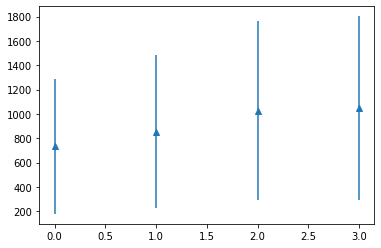

In [107]:
means = [m_f, m_s, m_t, m_q]
ss = [s_f, s_s, s_t, s_q]
x = np.arange(4)

plt.errorbar(x, means, ss, linestyle='None', marker='^')

plt.show()

In [108]:
mat_time = np.zeros((36, 31))
i = 0
for e in td:
    for a in e:
        mat_time[int(a/100),i] += 1
    i += 1
    
    

In [109]:
mat_time /= np.sum(mat_time, axis=0)

mat_time = np.cumsum(mat_time, axis=0)

In [110]:
len(out)

15674

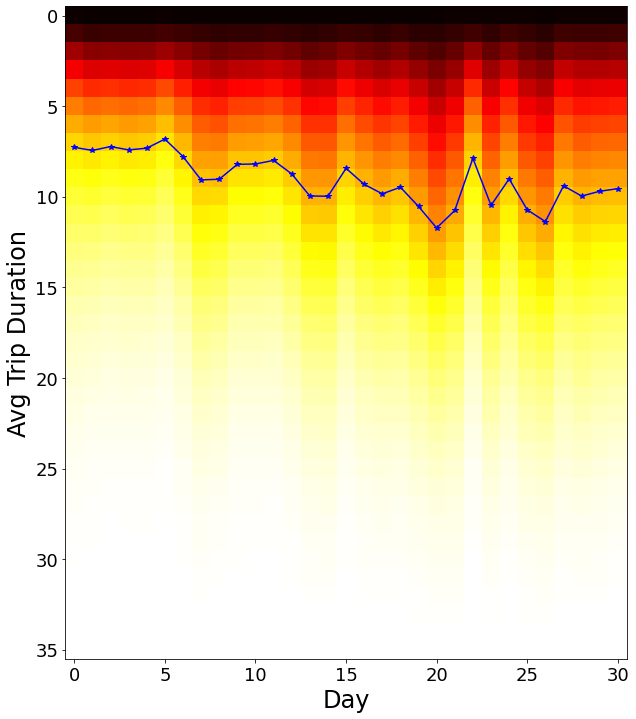

In [111]:
plt.figure(figsize=(14, 12))
plt.imshow(mat_time, cmap='hot')
plt.grid(False)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.xlabel('Day', fontsize=24)
plt.ylabel('Empirical CDF (1 hour)', fontsize=24)

plt.plot(np.arange(0, 31), np.array(m)/100, color='blue', marker='*')
# _ = plt.xticks(np.arange(1, 32), np.arange(1, 32))
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.xlabel('Day', fontsize=24)
plt.ylabel('Avg Trip Duration', fontsize=24)
plt.grid(False)
plt.savefig('./plots/time_duration_means.eps')
plt.savefig('./plots/cdf_timeduration.eps')



# Different Ratio Graphs # 

In [112]:
ths = 1

Day 4 loaded...
Unweighted number of rides (edges) : 28858.0


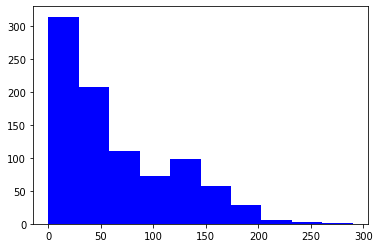

In [113]:
# Wednesday 4

days = [4]

# Find all connections with weights
adj_4_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_4_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_4_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_4 = adj_4_tot.copy()
    
adj_4[adj_4 < ths] = 0
adj_4[adj_4 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_4) / 2))

for i in range(n_tot_station):
    adj_4[i, i] = 0

# Create Undirected graph 
g_4 = nx.from_numpy_matrix(adj_4)
degs_4 = np.array([x[1] for x in g_4.degree])
plt.grid(False)
deg_4 = plt.hist(degs_4, color='blue')

Day 8 loaded...
Unweighted number of rides (edges) : 24228.0


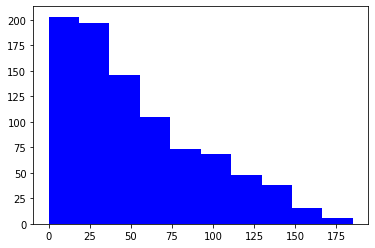

In [121]:
## Sunday 8

days = [8]

# Find all connections with weights
adj_8_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_8_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_8_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_8 = adj_8_tot.copy()
    
adj_8[adj_8 < ths] = 0
adj_8[adj_8 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_8) / 2))

for i in range(n_tot_station):
    adj_8[i, i] = 0

# Create Undirected graph 
g_8 = nx.from_numpy_matrix(adj_8)
degs_8 = np.array([x[1] for x in g_8.degree])
plt.grid(False)
_ = plt.hist(degs_8, color='blue')

Day 11 loaded...
Unweighted number of rides (edges) : 31915.0


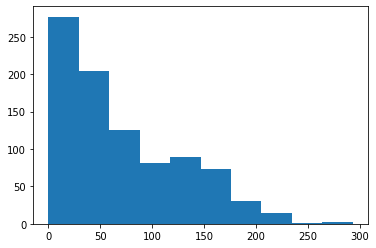

In [122]:
# Wed 11

days = [11]

# Find all connections with weights
adj_11_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_11_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_11_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_11 = adj_11_tot.copy()
    
adj_11[adj_11 < ths] = 0
adj_11[adj_11 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_11) / 2))

for i in range(n_tot_station):
    adj_11[i, i] = 0

# Create Undirected graph 
g_11 = nx.from_numpy_matrix(adj_11)
degs_11 = np.array([x[1] for x in g_11.degree])
_ = plt.hist(degs_11)

Day 15 loaded...
Unweighted number of rides (edges) : 20422.0


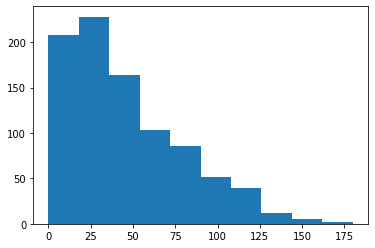

In [123]:
# Sunday 14

days = [15]

# Find all connections with weights
adj_15_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_15_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_15_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_15 = adj_15_tot.copy()
    
adj_15[adj_15 < ths] = 0
adj_15[adj_15 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_15) / 2))

for i in range(n_tot_station):
    adj_15[i, i] = 0

# Create Undirected graph 
g_15 = nx.from_numpy_matrix(adj_15)
degs_15 = np.array([x[1] for x in g_15.degree])
_ = plt.hist(degs_15)

Day 18 loaded...
Unweighted number of rides (edges) : 18562.5


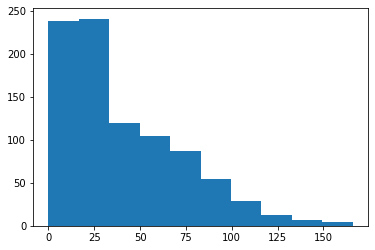

In [124]:
# Wed 18

days = [18]

# Find all connections with weights
adj_18_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_18_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_18_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_18 = adj_18_tot.copy()
    
adj_18[adj_18 < ths] = 0
adj_18[adj_18 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_18) / 2))

for i in range(n_tot_station):
    adj_18[i, i] = 0

# Create Undirected graph 
g_18 = nx.from_numpy_matrix(adj_18)
degs_18 = np.array([x[1] for x in g_18.degree])
_ = plt.hist(degs_18)

Day 22 loaded...
Unweighted number of rides (edges) : 12511.5


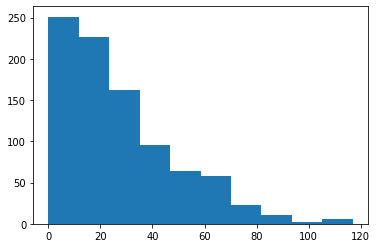

In [125]:
# Saturday 14

days = [22]

# Find all connections with weights
adj_22_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_22_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_22_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_22 = adj_22_tot.copy()
    
adj_22[adj_22 < ths] = 0
adj_22[adj_22 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_22) / 2))

for i in range(n_tot_station):
    adj_22[i, i] = 0

# Create Undirected graph 
g_22 = nx.from_numpy_matrix(adj_22)
degs_22 = np.array([x[1] for x in g_22.degree])
_ = plt.hist(degs_22)

Day 24 loaded...
Unweighted number of rides (edges) : 13160.5


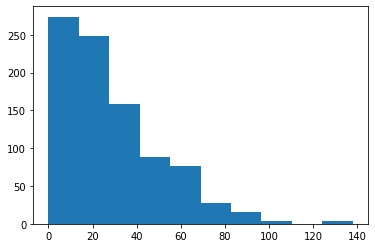

In [126]:
# Tues 24

days = [24]

# Find all connections with weights
adj_24_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_24_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_24_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_24 = adj_24_tot.copy()
    
adj_24[adj_24 < ths] = 0
adj_24[adj_24 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_24) / 2))

for i in range(n_tot_station):
    adj_24[i, i] = 0

# Create Undirected graph 
g_24 = nx.from_numpy_matrix(adj_24)
degs_24 = np.array([x[1] for x in g_24.degree])
_ = plt.hist(degs_24)

Day 29 loaded...
Unweighted number of rides (edges) : 6697.5


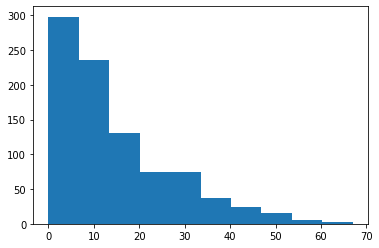

In [127]:
# Sunday 29

days = [29]

# Find all connections with weights
adj_29_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_29_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_29_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_29 = adj_29_tot.copy()
    
adj_29[adj_29 < ths] = 0
adj_29[adj_29 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_29) / 2))

for i in range(n_tot_station):
    adj_29[i, i] = 0

# Create Undirected graph 
g_29 = nx.from_numpy_matrix(adj_29)
degs_29 = np.array([x[1] for x in g_29.degree])
_ = plt.hist(degs_29)

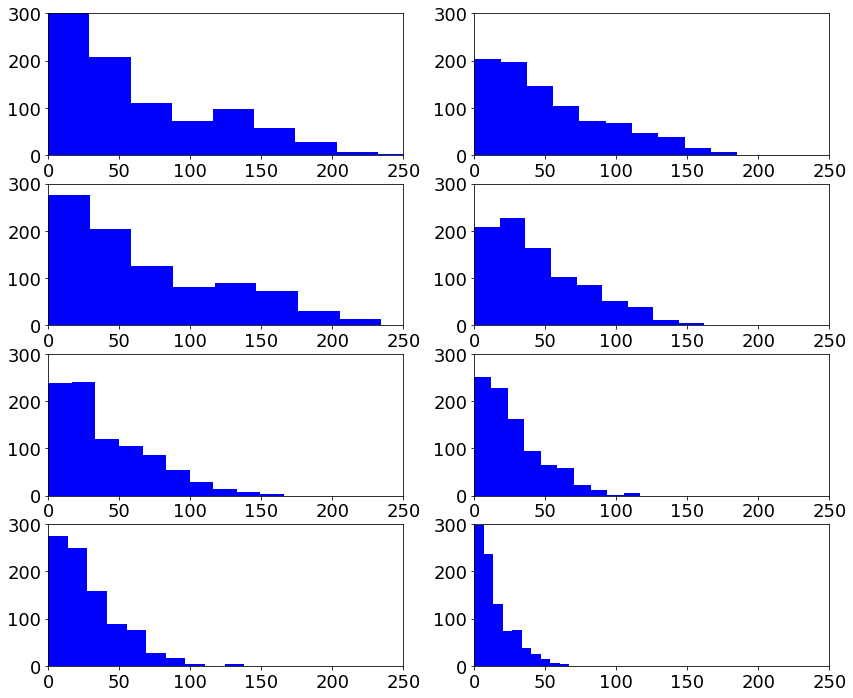

In [128]:
plt.figure(figsize=(14,12))

plt.subplot(4,2,1)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(np.arange(0,400,100), np.arange(0,400,100), fontsize=18)
plt.ylim(0,300)
plt.xlim(0, 250)
plt.grid(False)
_ = plt.hist(degs_4, color='blue')

plt.subplot(4,2,2)
plt.grid(False)
plt.ylim(0,300)
plt.xlim(0, 250)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(np.arange(0,400,100), np.arange(0,400,100), fontsize=18)
_ = plt.hist(degs_8, color='blue')

plt.subplot(4,2,3)
plt.ylim(0,300)
plt.xlim(0, 250)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(np.arange(0,400,100), np.arange(0,400,100), fontsize=18)
plt.grid(False)
_ = plt.hist(degs_11, color='blue')

plt.subplot(4,2,4)
plt.ylim(0,300)
plt.xlim(0, 250)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(np.arange(0,400,100), np.arange(0,400,100), fontsize=18)
plt.grid(False)
_ = plt.hist(degs_15, color='blue')

plt.subplot(4,2,5)
plt.grid(False)
plt.ylim(0,300)
plt.xlim(0, 250)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(np.arange(0,400,100), np.arange(0,400,100), fontsize=18)
_ = plt.hist(degs_18, color='blue')

plt.subplot(4,2,6)
plt.ylim(0,300)
plt.xlim(0, 250)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(np.arange(0,400,100), np.arange(0,400,100), fontsize=18)
plt.grid(False)
_ = plt.hist(degs_22, color='blue')

plt.subplot(4,2,7)
plt.ylim(0,300)
plt.xlim(0, 250)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(np.arange(0,400,100), np.arange(0,400,100), fontsize=18)
plt.grid(False)
_ = plt.hist(degs_24, color='blue')

plt.subplot(4,2,8)
plt.ylim(0,300)
plt.xlim(0, 250)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(np.arange(0,400,100), np.arange(0,400,100), fontsize=18)
plt.grid(False)
_ = plt.hist(degs_29, color='blue')

plt.savefig("plots/weekday_weekend_days_degrees.eps")

In [129]:
f_2_6 = np.sum(adj_2_6, axis=0)

In [130]:
np.max(f_2_6)

4974.0

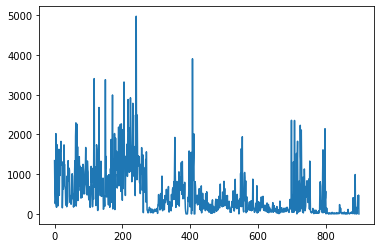

In [131]:
plt.plot(f_2_6)

In [132]:
len(g_2_6_tot)

899

'mat = np.arange(0, 4000, 250)\nmat = np.expand_dims(mat, axis=1)\nplt.imshow(mat, origin="lower", cmap=cmap, interpolation=\'nearest\')\nplt.grid(False)\n_ = plt.xticks([0], [\'\'])\n_ = plt.yticks([0, 3, 6, 9, 12], [0,0.3,0.6,0.9,1.2])\nplt.set_cmap(cmap=cmap)'

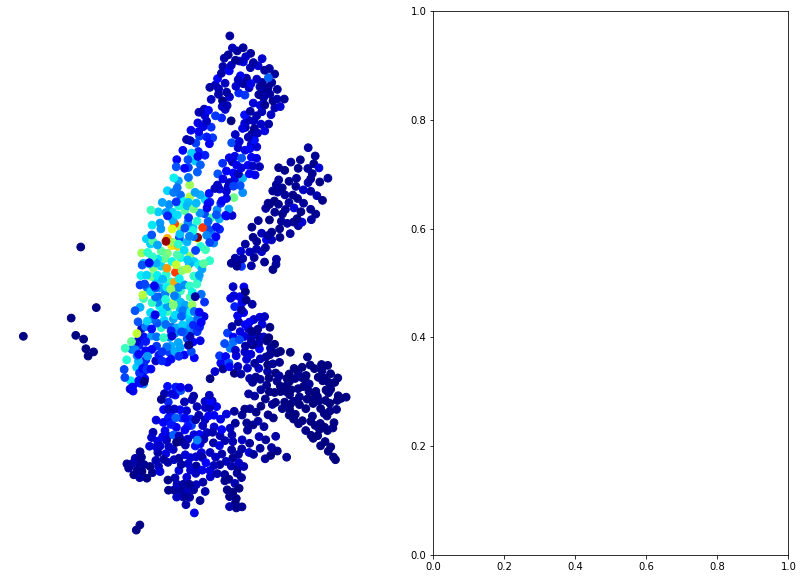

In [133]:
cmap = plt.cm.get_cmap('jet')


plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_2_6_tot, locations, node_size=60, node_color=f_2_6, cmap=cmap, vmin=0, vmax=4000)
# nx.draw_networkx_edges(g_2_6_tot, locations, alpha=0.8, width=0.2, edge_color='black',aplha=0.8)

plt.subplot(1,2,2)

"""mat = np.arange(0, 4000, 250)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 12], [0,0.3,0.6,0.9,1.2])
plt.set_cmap(cmap=cmap)"""

# _ = plt.savefig('./plots/first_graph_week_absolute.jpeg')

# mplleaflet.show()


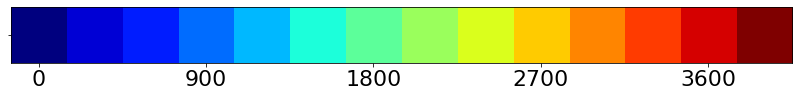

In [134]:
plt.figure(figsize=(14,10))
mat = np.arange(0, 4000, 300)
mat = np.expand_dims(mat, axis=0)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], mat[0, [0, 3, 6, 9, 12]], fontsize=22)
plt.set_cmap(cmap=cmap)

plt.savefig('plots/bs_abs_cmap.jpeg')

In [135]:
f_4 = np.sum(adj_4_tot, axis=0)
f_8 = np.sum(adj_8_tot, axis=0)
f_11 = np.sum(adj_11_tot, axis=0)
f_15 = np.sum(adj_15_tot, axis=0)
f_18 = np.sum(adj_18_tot, axis=0)
f_22 = np.sum(adj_22_tot, axis=0)
f_24 = np.sum(adj_24_tot, axis=0)
f_29 = np.sum(adj_29_tot, axis=0)

In [136]:
d_4 = np.array([ e[1] for e in g_4.degree()])
d_11 = np.array([ e[1] for e in g_11.degree()])
d_18 = np.array([ e[1] for e in g_18.degree()])
d_24 = np.array([ e[1] for e in g_24.degree()])

d_11 = d_11/ d_4
d_18 = d_18/ d_4
d_24 = d_24 / d_4

/home/runner/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/runner/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/runner/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/runner/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/runner/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/runner/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


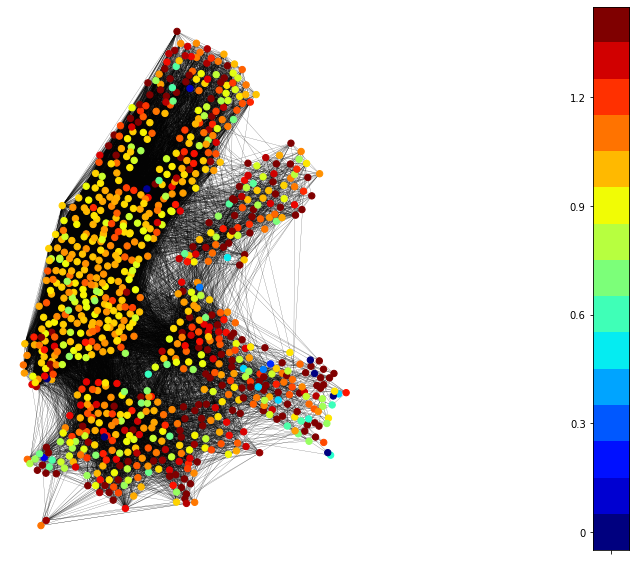

In [137]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_11, locations, node_size=40, node_color=d_11, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_11, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)

mat = np.arange(0,1.5, 0.1)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 12], [0,0.3,0.6,0.9,1.2])
plt.set_cmap(cmap=cmap)

_ = plt.savefig('./plots/degree_11_graph_0_1.jpeg')

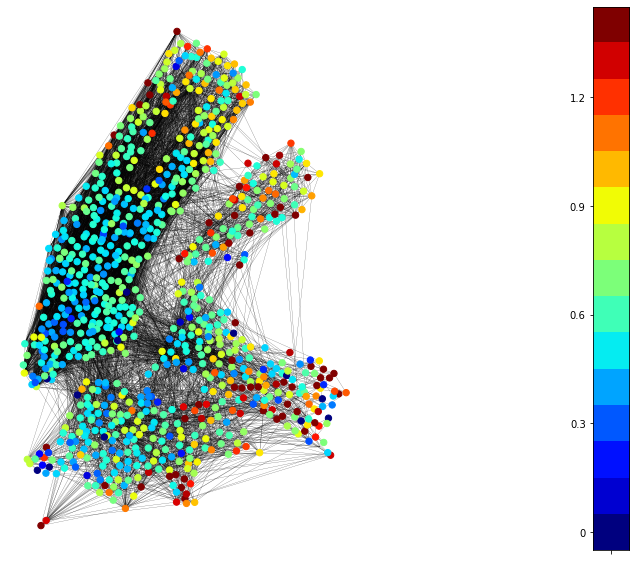

In [138]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_18, locations, node_size=40, node_color=d_18, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_24, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)

mat = np.arange(0,1.5, 0.1)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 12], [0,0.3,0.6,0.9,1.2])
plt.set_cmap(cmap=cmap)

_ = plt.savefig('./plots/degree_18_graph_0_1.jpeg')

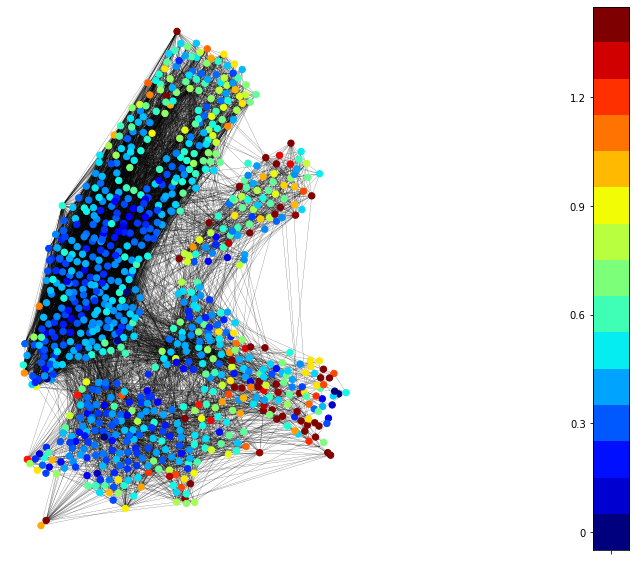

In [139]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_24, locations, node_size=40, node_color=d_24, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_24, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)

mat = np.arange(0,1.5, 0.1)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 12], [0,0.3,0.6,0.9,1.2])
plt.set_cmap(cmap=cmap)

_ = plt.savefig('./plots/degree_24_graph_0_1.jpeg')

In [140]:
import warnings
warnings.filterwarnings('ignore')

In [141]:
f_4[f_4 == 0] = 1

In [142]:
r_4 = f_4 / f_4
r_8 = f_8 / f_4
r_11 = f_11 / f_4
r_15 = f_15 / f_4
r_18 = f_18 / f_4
r_22 = f_22 / f_4
r_24 = f_24 / f_4
r_29 = f_29 / f_4

In [143]:
print(np.max(r_4))
print(np.max(r_8))
print(np.max(r_11))
print(np.max(r_15))
print(np.max(r_18))
print(np.max(r_22))
print(np.max(r_24))
print(np.max(r_29))

1.0
18.0
11.0
23.0
9.0
66.0
47.0
25.0


In [144]:
print(np.max(f_4))
print(np.max(f_11))
print(np.max(f_18))
print(np.max(f_24))

print(np.min(f_4))
print(np.min(f_11))
print(np.min(f_18))
print(np.min(f_24))

1197.0
1040.0
412.0
305.0
1.0
0.0
0.0
0.0


In [145]:
cmap = plt.cm.get_cmap('jet')

In [146]:
mat

array([[0. ],
       [0.1],
       [0.2],
       [0.3],
       [0.4],
       [0.5],
       [0.6],
       [0.7],
       [0.8],
       [0.9],
       [1. ],
       [1.1],
       [1.2],
       [1.3],
       [1.4]])

In [147]:
mat.shape

(15, 1)

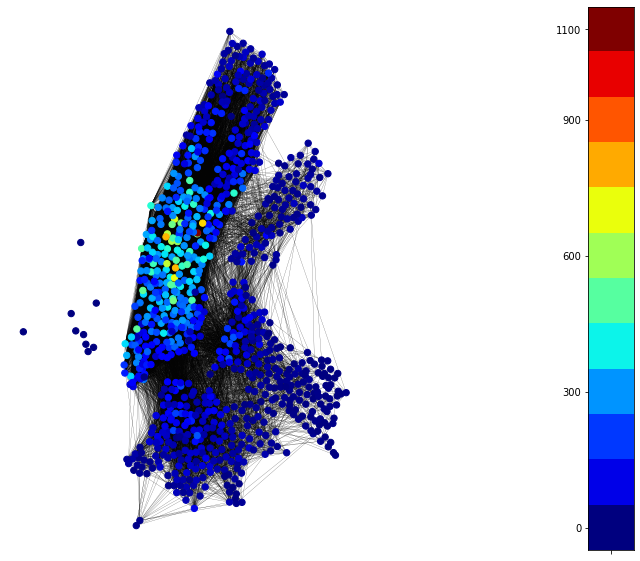

In [148]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_4, locations, node_size=40, node_color=f_4, cmap=cmap, vmin=0, vmax=1197)
nx.draw_networkx_edges(g_4, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
"""plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_8, locations, node_size=40, node_color=r_8, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_8, locations, alpha=0.8, width=0.2, edge_color='black')"""

mat = np.arange(0,1197, 100)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 11], mat[[0,3, 6, 9, 11],0])
plt.set_cmap(cmap=cmap)

_ = plt.savefig('./plots/day_4_abs.jpeg')

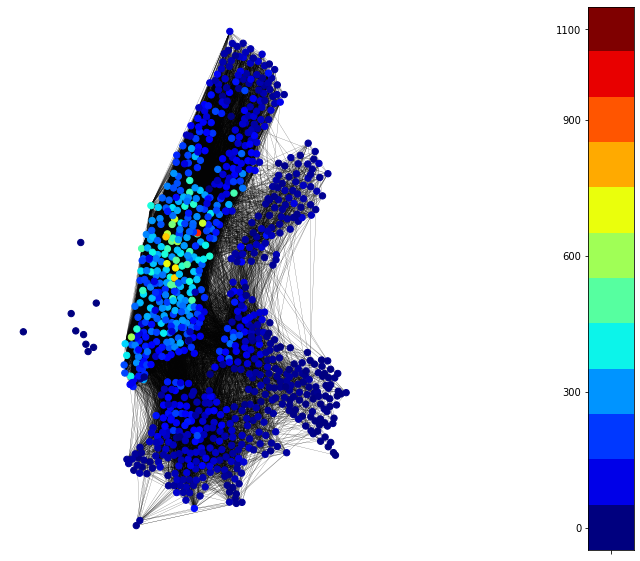

In [149]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_11, locations, node_size=40, node_color=f_11, cmap=cmap, vmin=0, vmax=1197)
nx.draw_networkx_edges(g_11, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
"""plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_15, locations, node_size=40, node_color=r_15, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_15, locations, alpha=0.8, width=0.2, edge_color='black')"""

mat = np.arange(0,1197, 100)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 11], mat[[0,3, 6, 9, 11],0])
plt.set_cmap(cmap=cmap)
_ = plt.savefig('./plots/day_11_abs.jpeg')

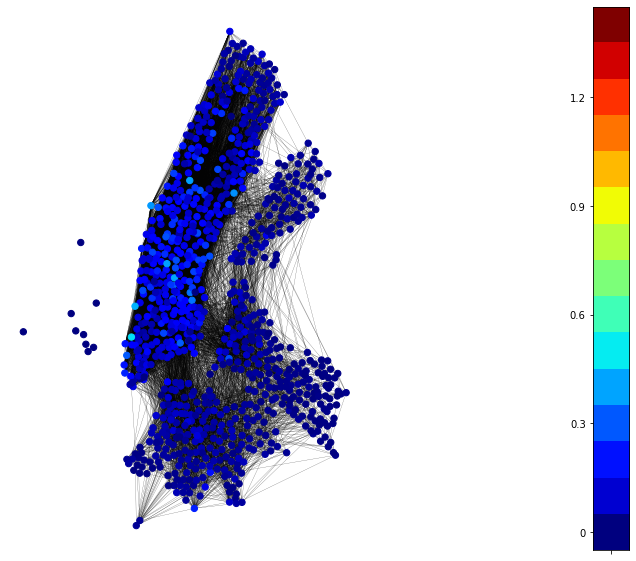

In [150]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_18, locations, node_size=40, node_color=f_18, cmap=cmap, vmin=0, vmax=1197)
nx.draw_networkx_edges(g_18, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
"""plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_22, locations, node_size=40, node_color=r_22, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_22, locations, alpha=0.8, width=0.2, edge_color='black')"""

mat = np.arange(0,1.5, 0.1)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 12], [0,0.3,0.6,0.9,1.2])
plt.set_cmap(cmap=cmap)


_ = plt.savefig('./plots/day_18_abs.jpeg')

#mplleaflet.show()

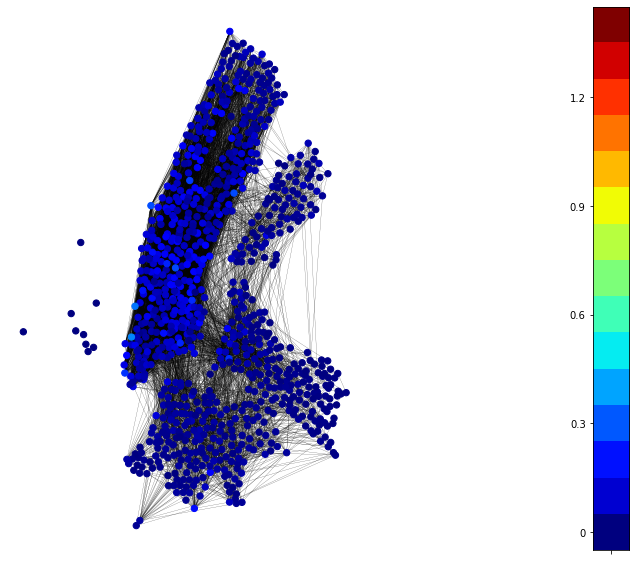

In [151]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_24, locations, node_size=40, node_color=f_24, cmap=cmap, vmin=0, vmax=1197)
nx.draw_networkx_edges(g_24, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
"""plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_29, locations, node_size=40, node_color=r_29, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_29, locations, alpha=0.8, width=0.2, edge_color='black')"""

mat = np.arange(0,1.5, 0.1)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 12], [0,0.3,0.6,0.9,1.2])
plt.set_cmap(cmap=cmap)

_ = plt.savefig('./plots/day_24_abs.jpeg')

# mplleaflet.show()

In [152]:
# same for degree



In [153]:
l = [len(e) for k,e in hour_rides(d[3], d[4], df).items()]

In [154]:
# Important nodes first week
s = set(np.argsort(f_2_6)[-200:])
g_top_2_6 = g_2_6.copy()
rem = [e for e in g_top_2_6.nodes() if e not in s ]

for e in rem:
    g_top_2_6.remove_node(e)

In [155]:
plt.figure(figsize=(12,8))
plt.grid(False)
nx.draw_networkx_nodes(g_top_2_6, locations, node_size=40, node_color='black')
nx.draw_networkx_edges(g_top_2_6, locations, alpha=0.8, width=0.2, edge_color='gray')
plt.axis(False)

mplleaflet.show()

In [156]:
# Important nodes last week
s = set(np.argsort(f_23_27)[-200:])
g_top_23_27 = g_23_27.copy()
rem = [e for e in g_top_23_27.nodes() if e not in s ]

for e in rem:
    g_top_23_27.remove_node(e)

In [157]:
plt.figure(figsize=(12,8))
plt.grid(False)
nx.draw_networkx_nodes(g_top_23_27, locations, node_size=40, node_color='black')
nx.draw_networkx_edges(g_top_23_27, locations, alpha=0.8, width=0.2, edge_color='gray')
plt.axis(False)

mplleaflet.show()

# Heat Diffusion #

In [158]:
from pygsp.filters import Heat

In [159]:
# good nodes , 40, 600, 524

In [160]:
df[df['start station id'] == 3398]

tripduration                 starttime                  stoptime  \
2247              705  2020-03-01 08:54:25.1390  2020-03-01 09:06:11.0050   
6688              265  2020-03-01 11:35:06.9460  2020-03-01 11:39:32.2990   
9256              369  2020-03-01 12:33:43.1620  2020-03-01 12:39:52.5280   
9808              195  2020-03-01 12:44:53.7000  2020-03-01 12:48:09.2890   
11406             646  2020-03-01 13:18:55.4200  2020-03-01 13:29:41.9120   
...               ...                       ...                       ...   
1041370           712  2020-03-30 10:10:41.4350  2020-03-30 10:22:33.8790   
1050155           433  2020-03-30 17:56:29.7430  2020-03-30 18:03:43.0780   
1054865           667  2020-03-31 08:22:03.2510  2020-03-31 08:33:10.3690   
1057685           272  2020-03-31 12:40:14.5220  2020-03-31 12:44:47.3610   
1062749          2880  2020-03-31 17:00:43.5810  2020-03-31 17:48:44.2780   

         start station id start station name  start station latitude  \
2247                 3398    Smith St & 9 St               40.674696   
6688                 3398    Smith St & 9 St               40.674696   
9256                 3398    Smith St & 9 St               40.674696   
9808                 3398    Smith St & 9 St               40.674696   
11406                3398    Smith St & 9 St               40.674696   
...                   ...                ...                     ...   
1041370              3398    Smith St & 9 St               40.674696   
1050155              3398    Smith St & 9 St               40.674696   
1054865              3398    Smith St & 9 St               40.674696   
1057685              3398    Smith St & 9 St               40.674696   
1062749              3398    Smith St & 9 St               40.674696   

         start station longitude  end station id             end station name  \
2247                  -73.997858            3310                14 St & 7 Ave   
6688                  -73.997858            3382        Carroll St & Smith St   
9256                  -73.997858            3347    Van Brunt St & Wolcott St   
9808                  -73.997858            3382        Carroll St & Smith St   
11406                 -73.997858            3402          Court St & State St   
...                          ...             ...                          ...   
1041370               -73.997858             323  Lawrence St & Willoughby St   
1050155               -73.997858            3410            Dean St & Hoyt St   
1054865               -73.997858             323  Lawrence St & Willoughby St   
1057685               -73.997858            3324                3 Ave & 14 St   
1062749               -73.997858            3398              Smith St & 9 St   

         end station latitude  end station longitude  bikeid    usertype  \
2247                40.663779             -73.983968   32249  Subscriber   
6688                40.680611             -73.994758   41745  Subscriber   
9256                40.677343             -74.012751   39730  Subscriber   
9808                40.680611             -73.994758   35324  Subscriber   
11406               40.690238             -73.992031   40806  Subscriber   
...                       ...                    ...     ...         ...   
1041370             40.692362             -73.986317   40234  Subscriber   
1050155             40.686444             -73.987591   40600  Subscriber   
1054865             40.692362             -73.986317   40565  Subscriber   
1057685             40.668546             -73.993333   34956  Subscriber   
1062749             40.674696             -73.997858   41835    Customer   

         birth year  gender  
2247           1990       2  
6688           1983       1  
9256           1986       1  
9808           1984       2  
11406          1986       2  
...             ...     ...  
1041370        1980       1  
1050155        1969       0  
1054865        1988       1  
1057685        1984       2  
106

In [161]:
source_nodes = [780]

In [162]:
t = np.arange(0, 100)

h = Heat(G_2_6, tau=t)

source = np.zeros(G_2_6.U.shape[0])
source[transform_source(source_nodes, isolated_nodes_2_6)] = 100

y_2_6 = h.filter(source)


In [163]:
for e in sorted(isolated_nodes_2_6):
    y_2_6 = np.insert(y_2_6, e, 0, axis=0)

In [164]:
t = np.arange(0, 100)

h = Heat(G_23_27, tau=t)

source = np.zeros(G_23_27.U.shape[0])
source[transform_source(source_nodes, isolated_nodes_23_27)] = 100

y_23_27 = h.filter(source)

In [165]:
for e in sorted(isolated_nodes_23_27):
    y_23_27 = np.insert(y_23_27, e, 0, axis=0)

In [166]:
hotmap = plt.cm.get_cmap('viridis')

In [167]:
node_size_2 = np.ones(g_2_6_tot.number_of_nodes()) * 40
node_size_2[source_nodes[0]] = 60
node_size_23 = np.ones(g_23_27_tot.number_of_nodes()) * 40
node_size_23[source_nodes[0]] = 60

In [168]:
node_size_2.shape

(899,)

In [169]:
time = 1
node = source_nodes[0]

In [170]:
plt.figure(figsize=(12,8))
plt.plot(vec_2_6)
plt.plot(vec_2_6_6, alpha=0.5)

NameError: name 'vec_2_6' is not defined

<Figure size 864x576 with 0 Axes>

In [171]:
plt.figure(figsize=(12,8))
plt.plot(vec_23_27)
plt.plot(vec_23_27_6, alpha=0.5)

NameError: name 'vec_23_27' is not defined

<Figure size 864x576 with 0 Axes>

In [173]:
vec_2_6 = y_2_6[:,time].copy()
vec_2_6[vec_2_6 > 1] = 1
colors_2_6 = [matplotlib.colors.to_hex(e, keep_alpha=False) for e in hotmap(vec_2_6)]

vec_2_6_6 = y_2_6[:,9].copy()
vec_2_6_6[vec_2_6_6 > 1] = 1
colors_2_6_6 = [matplotlib.colors.to_hex(e, keep_alpha=False) for e in hotmap(vec_2_6_6)]

vec_23_27 = y_23_27[:, time].copy()
vec_23_27[vec_23_27 > 1] = 1
colors_23_27 = [matplotlib.colors.to_hex(e, keep_alpha=False) for e in hotmap(vec_23_27)]

vec_23_27_6 = y_23_27[:,9].copy()
vec_23_27_6[vec_23_27_6 > 1] = 1
colors_23_27_6 = [matplotlib.colors.to_hex(e, keep_alpha=False) for e in hotmap(vec_23_27_6)]

colors_2_6[source_nodes[0]] = matplotlib.colors.to_hex('red', keep_alpha=False)
colors_23_27[source_nodes[0]] = matplotlib.colors.to_hex('red', keep_alpha=False)


In [174]:
draw_nodes_2 = [x for x in g_2_6_tot.nodes() if x not in out_nodes]
draw_edges_2 = [x for x in g_2_6_tot.edges() if x[0] not in out_nodes and x[1] not in out_nodes]

draw_nodes_23 = [x for x in g_23_27_tot.nodes() if x not in out_nodes]
draw_edges_23 = [x for x in g_23_27_tot.edges() if x[0] not in out_nodes and x[1] not in out_nodes]



In [175]:
for x in reversed(list(out_nodes)):
    node_size_2 = np.delete(node_size_2, x)
    colors_2_6 = np.delete(colors_2_6, x)

In [176]:
for x in reversed(list(out_nodes)):
    node_size_23 = np.delete(node_size_23, x)
    colors_23_27 = np.delete(colors_23_27, x)

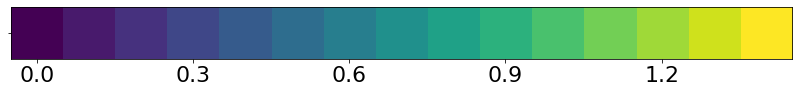

In [177]:
plt.figure(figsize=(14,15))
mat = np.arange(0, 1, 0.1)
label = np.array([round(x, 2) for x in mat])
mat = np.expand_dims(mat, axis=0)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')

plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], label[[0, 3, 6, 9, 12]], fontsize=22)
plt.set_cmap(cmap=hotmap)

plt.savefig('plots/heat_cmap.jpg')

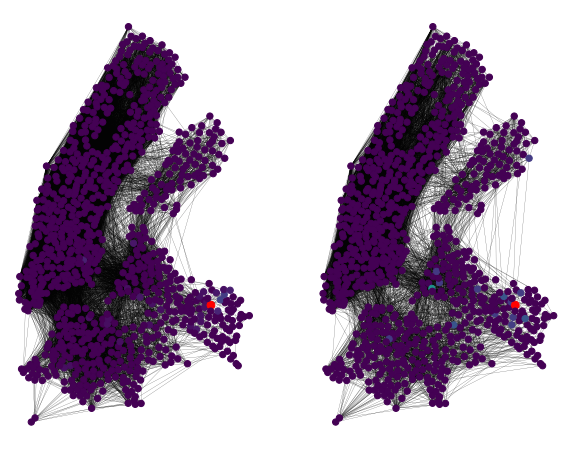

In [178]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)

plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_2_6_tot, locations, nodelist=draw_nodes_2,  node_size=node_size_2, node_color=colors_2_6, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_2_6_tot, locations, edgelist=draw_edges_2, alpha=0.8, width=0.2, edge_color='black')


plt.subplot(1,2,2)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_23_27_tot, locations, nodelist=draw_nodes_23, node_size=node_size_23, node_color=colors_23_27, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_23_27_tot, locations, edgelist=draw_edges_23, alpha=0.8, width=0.2, edge_color='black')

plt.savefig('plots/heat_{}.jpeg'.format(source_nodes[0]))

In [ ]:
two_order_ns = set()
n = source_nodes[0]
two_order_ns.add(n)
for e in nx.neighbors(g_2_6_tot, n):
    two_order_ns.add(e)
new_nodes = set()
for e in two_order_ns:
    for n in nx.neighbors(g_2_6_tot, e):
        new_nodes.add(n)
        
two_order_ns = two_order_ns.union(new_nodes)
    
g = nx.subgraph(g_2_6, list(two_order_ns))

In [ ]:
plt.plot(np.ravel(nx.adj_matrix(g_2_6_tot)[source_nodes[0],:].todense()))

In [ ]:
np.sum(nx.adj_matrix(g_2_6_tot)[source_nodes[0],:].todense())

In [ ]:
np.sum(nx.adj_matrix(g_23_27_tot)[source_nodes[0],:].todense())

In [ ]:
plt.plot(np.ravel(nx.adj_matrix(g_23_27_tot)[source_nodes[0],:].todense()))

In [ ]:
two_order_ns = set()
n = source_nodes[0]
two_order_ns.add(n)
for e in nx.neighbors(g_23_27_tot, n):
    two_order_ns.add(e)
new_nodes = set()
for e in two_order_ns:
    for n in nx.neighbors(g_23_27_tot, e):
        new_nodes.add(n)
        
two_order_ns = two_order_ns.union(new_nodes)
    
g = nx.subgraph(g_23_27, list(two_order_ns))

In [ ]:
cols=[]
for e in g.nodes:
    if e==source_nodes[0]:
        cols.append('red')
    else:
        cols.append('black')

In [ ]:
plt.subplot(1,2,1)
plt.grid(False)
nx.draw_networkx_nodes(g, locations, node_size=65, node_color=cols)
nx.draw_networkx_edges(g, locations, alpha=0.8, width=0.2, edge_color='black')
plt.axis(False)

mplleaflet.show()

In [ ]:
3398

In [ ]:
df[df['start station id'] == 3398]

In [ ]:
plt.figure(figsize=(12,10))
mat = np.arange(0, 1, 0.075)
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=hotmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 4, 8, 12], [0,0.3,0.6,0.9], fontsize=18)
plt.savefig('plots/heat_cmap.eps')

In [ ]:
index_23 = dict(zip(g_23_27.nodes(), np.arange(g_23_27.number_of_nodes())))
cols_bridge = np.zeros(g_23_27.number_of_nodes())

In [ ]:
upper_man_idx = list(upper_man_idx)
queens_idx = list(queens_idx)

In [ ]:
# Illegal Bridges

for e in upper_man_idx[:100]:
    cols_bridge[index_23[e]] = 1

In [ ]:
plt.figure(figsize=(8, 12))

plt.grid(False)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=cols_bridge)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')
plt.axis(False)

In [ ]:
index_2_6 = dict(zip(g_2_6.nodes(), np.arange(g_2_6.number_of_nodes())))


In [ ]:
zoom = []
for k, v in locations.items():
    if v[0] > -73.96 and v[0] < -73.90 and v[1] > 40.77 and v[1] < 40.80:
        zoom.append(k)
zoom = np.array(zoom)

In [ ]:
"""
 v[0] > -73.96 and v[0] < -73.90 and v[1] > 40.76 and v[1] < 40.80
manhattan = list(np.arange(55))
manhattan.extend([60, 69, 96, 99])
queens = list(set(np.arange(102)).difference(set(manhattan)))"""

In [ ]:
manhattan = list(np.arange(20))
# manhattan.extend([60, 69, 96, 99])
queens = list(set(np.arange(40)).difference(set(manhattan)))

In [ ]:
len(zoom)

In [ ]:
cols_bridge = ['blue' for e in np.arange(g_2_6.number_of_nodes())]

for e in zoom[manhattan]:
    if index_2_6.get(e) is not None:
        cols_bridge[index_2_6[e]] = 'yellow'

for e in zoom[queens]:
    if index_2_6.get(e) is not None:
        cols_bridge[index_2_6[e]] = 'red'
        
plt.figure(figsize=(8, 12))

plt.grid(False)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=cols_bridge, cmap=colors_bridge)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')
plt.axis(False) 

# mplleaflet.show()

In [ ]:
# first_week

# start station id --> 3 
# end station id --> 7
set_manhattan = set(zoom[manhattan])
set_queens = set(zoom[queens])

start_row = d[2] 
end_row = d[7]

first_cross = []

for row in df.iloc[start_row:end_row].iterrows():
    if id_index[row[1][3]] in set_manhattan and id_index[row[1][7]] in set_queens:
        first_cross.append(row[0])
    elif id_index[row[1][7]] in set_manhattan and id_index[row[1][3]] in set_queens:
        first_cross.append(row[0])
    

In [ ]:
# last

# start station id --> 3 
# end station id --> 7
set_manhattan = set(zoom[manhattan])
set_queens = set(zoom[queens])

start_row = d[23] 
end_row = d[28]

last_cross = []

for row in df.iloc[start_row:end_row].iterrows():
    if id_index[row[1][3]] in set_manhattan and id_index[row[1][7]] in set_queens:
        last_cross.append(row[0])
    elif id_index[row[1][7]] in set_manhattan and id_index[row[1][3]] in set_queens:
        last_cross.append(row[0])
    

In [ ]:
df.iloc[first_cross]['tripduration'].describe()


In [ ]:
f = np.array(df.iloc[first_cross]['tripduration'])
f = f[f<2400]

In [ ]:
l = np.array(df.iloc[last_cross]['tripduration'])
l = l[l<2400]

In [ ]:
_ = plt.hist(f, color='blue')
plt.grid(False)

In [ ]:
_ = plt.hist(l, color='blue')
plt.grid(False)

In [ ]:
df.iloc[last_cross]['start station id']

# Metro Data #

In [ ]:
# import shapefile as shp
import seaborn as sns
from pyproj import Proj, transform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from shapely.geometry import shape, Point

import shapefile

from utils.shapefile import read_shapefile, plot_shape, plot_map, plot_map_fill

In [ ]:
# UTILS

def find_day_metro(day, month, df):
    day = str_int(day)
    month = str_int(month)
    ids = []
    for index, row in df.iterrows():
        if row['date'].split('-')[-1] == day and row['date'].split('-')[-2] == month:
            ids.append(index)
    return ids
        
def str_int(i):
    if i < 10:
        return '0' + str(i)
    else:
        return str(i)

def calc_color(data, num_bins=None, ref_bins=None, name='YlOrBr'):
    
    cmap=plt.get_cmap(name)
    
    if ref_bins is None:
        new_data, bins = pd.qcut(data, num_bins, retbins=True, labels=list(range(num_bins)))
    else:
        bins = ref_bins
        num_bins = len(ref_bins)-1
        new_data = pd.cut(data, ref_bins, include_lowest=True, labels=list(range(num_bins)))
    m = num_bins - 1
    color_ton = []
    for val in new_data:
        color_ton.append(matplotlib.colors.to_hex(cmap(val/m), keep_alpha=False)) 
    
    #plot color map
    
    """cat = np.arange(num_bins)
    ex = cat / (num_bins-1)
    ex = np.expand_dims(ex, 1)
    
    plt.imshow(ex, cmap=cmap)
    plt.grid(False)
    plt.yticks([0], [''])
    _ = plt.axis('on')"""

    return color_ton, bins

In [ ]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(12,8))

%matplotlib inline

sf = shapefile.Reader("./data/shapefiles_/ZIP_CODE_040114.dbf")

df_shape = read_shapefile(sf)

In [ ]:
metro_data = pd.read_csv('./data/metro/metro_whole_station.csv')

In [ ]:
metro_data.head()

In [ ]:
# Find Geo-Coordinates for stations

stat_geo = {}
for index, row in metro_data.iterrows():
    coor = np.array([row['gtfs_longitude'], row['gtfs_latitude']])
    stat_geo[row['stop_name']] = coor
    
# Find xlim and ylim 
x_lim = [100, -100]
y_lim = [100, 0]
for k,v in locations.items():
    
    if v[0] < x_lim[0]:
        x_lim[0] = v[0]
    elif v[0] > x_lim[1]:
        x_lim[1] = v[0]
        
    if v[1] < y_lim[0]:
        y_lim[0] = v[1]
    elif v[1] > y_lim[1]:
        y_lim[1] = v[1]
        
        


In [ ]:
# Find Zip Code for Stations

points = [(k, Point(v)) for k,v in stat_geo.items()]
multis = [(e.record[0], shape(e.shape.__geo_interface__)) for e in sf.shapeRecords()]

stat_zip = {}

for stat, pt in points:
    point = shape(pt)
    for zip_code, poly in multis:
        if point.within(poly): 
            stat_zip[stat] = zip_code

In [ ]:
# Find Zip Code for BS - Stations

points_bs = [(k, Point(v)) for k,v in locations.items()]
multis_bs = [(e.record[0], shape(e.shape.__geo_interface__)) for e in sf.shapeRecords()]

bs_zip = {}
not_found = []
for stat, pt in points_bs:
    point = shape(pt)
    for zip_code, poly in multis_bs:
        if point.within(poly): 
            bs_zip[stat] = zip_code
    if bs_zip.get(stat) is None:
        not_found.append(stat)
        
# Find f_2_6_tot with all nodes 

f_24_tot = list(np.sum(adj_24_tot, axis=0))


In [ ]:
"""for n in reversed(not_found):
    del f_2_6_tot[n]"""

f_24_tot = np.array(f_24_tot)



In [ ]:
zip_index = dict(zip(df_shape['ZIPCODE'], np.arange(len(df_shape))))

In [ ]:
import pickle 

In [ ]:
# Create indexes for March 

"""march_ids = []
for d in range(1, 32):
    march_ids.append(find_day_metro(d, 3, metro_data))

with open('./data/python_variables/march_ids.pickle', 'wb') as file:
    pickle.dump(march_ids, file)
"""

In [ ]:
with open('./data/python_variables/march_ids.pickle', 'rb') as file:
    march_ids = pickle.load(file)

In [ ]:
# Find Daily runs

days = [4, 11, 18, 24]

days_metro = dict()

for day in days:
    days_metro[day] = {}
    for index, row in metro_data.iloc[march_ids[day-1]].iterrows():
        zip_code = stat_zip.get(row['stop_name'])
        if zip_code is not None:
            if days_metro[day].get(zip_code) is None:
                days_metro[day][zip_code] = row['entries'] 
            else:
                days_metro[day][zip_code] += row['entries'] 
    print("Aggregated day {}".format(day))

# Collect By indexes

idxs = {}
for day in days:
    idxs[day] = []
    idxs[day].append(np.array([zip_index[str(e)] for e in days_metro[day].keys() ]))
    idxs[day].append(np.array(list(days_metro[day].values())))
    idxs[day].append(idxs[day][1] / idxs[4][1])

In [ ]:
assert len(idxs[days[0]][1]) == len(idxs[days[0]][0])

In [ ]:
i = 0
for e in d:
    if np.isnan(e):
        print(i)
    i += 1

In [ ]:
for k, v in idxs.items():
    v[1] = np.where(v[1] > 150000, 150000, v[1])

In [ ]:
ref, bins = pd.qcut(idxs[11][2], 12, retbins=True, labels=list(range(12)))

In [ ]:
bins_name = ['0', '0.1', '0.2', '0.3', ]

In [ ]:
bin_lab = np.array([str(e) for e in bins])

In [ ]:
bin_lab

In [ ]:
idxs[11][1][idxs[11][1] > 150000]

In [ ]:
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
mat = bins.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 2, 5, 8, 10 ], (bins[[0, 2, 5, 8,  10]]), fontsize=18)
plt.savefig('plots/metro_relative_cmap.eps')

In [ ]:
bins.shape

In [ ]:
for k, v in idxs.items():

    color_ton, _ = calc_color(v[1], ref_bins=bins, name='jet')

    ax = plot_map_fill(v[0], sf, color_ton, x_lim=x_lim, y_lim=y_lim, figsize=(8,6))

    _ = plt.savefig('plots/metro{}.eps'.format(k))
    """nx.draw_networkx_nodes(g_2_6, locations, node_size=29, node_color='black', ax=ax)
    nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)
    nx.draw_networkx_nodes(g, stations_geo, node_size=20 )"""
    
    plt.savefig('plots/metro_{}_abs.eps'.format(k))

In [ ]:
len(f_24_tot)

In [ ]:
len(bs_zip)

In [ ]:
# Find BS runs
bs_agg = dict()

for k, v in enumerate(f_24_tot):
    zip_code = bs_zip.get(k)
    if zip_code is not None:
        if bs_agg.get(zip_code) is None:
            bs_agg[zip_code] = v
        else:
            bs_agg[zip_code] += v 
print("Aggregated week one")

# Collect By indexes

bs_tot = []

bs_tot.append(np.array([zip_index[str(e)] for e in bs_agg.keys() ]))
bs_tot.append(np.array(list(bs_agg.values())))


In [ ]:
plt.plot(sorted(bs_tot[1]))

In [ ]:
bs_tot[1][bs_tot[1] > 6000]

In [ ]:
# Plot BS Aggregated per ZIP CODE

# bs_tot[1] = np.where(bs_tot[1] > 6000, 6000, bs_tot[1] )

ref, bins = pd.qcut(bs_tot[1], 12, retbins=True, labels=list(range(12)))
bin_lab = np.array([int(e) for e in bins])

cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
mat = bins.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], (bin_lab[[0, 3, 6, 9, 12]]), fontsize=18)

plt.savefig('plots/zip_bs_cmap_4.eps')

In [ ]:


# bs_tot[1] = np.where(bs_tot[1] > 2000, 2000, bs_tot[1])

color_ton, _ = calc_color(bs_tot[1], ref_bins=bins, name='jet')

ax = plot_map_fill(bs_tot[0], sf, color_ton, x_lim=x_lim, y_lim=y_lim, figsize=(8,6))

"""nx.draw_networkx_nodes(g_2_6, locations, node_size=29, node_color='black', ax=ax)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)"""

_ = plt.savefig('plots/bs_zip_24.eps')

In [ ]:
s = 0
for k, v in bs_zip.items():
    if v == '11231':
        s+=f_2_6_plot[k]

In [ ]:
zip_index['11231']

In [ ]:
# Left

zip_left = pd.read_csv('./data/zip_left.csv', names=['zipcode', 'perc'], header=None)
    


In [ ]:
zip_left.head()

In [ ]:
idx_left = [zip_index[str(e)] for e in zip_left['zipcode']]

In [ ]:
bins = [0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8]

In [ ]:
color_ton, _ = calc_color(list(zip_left['perc']), ref_bins=bins)

ax = plot_map_fill(idx_left, sf, color_ton, x_lim=[-74.05, -73.8], y_lim=[40.6, 40.9], figsize=(8,6))

In [ ]:
"""import geopandas as gpd

tmp = gpd.GeoDataFrame.from_file('./data/shapefiles/ZIP_CODE_040114.shp')

tmpWGS84 = tmp.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

tmpWGS84.to_file('./data/shapefiles_/ZIP_CODE_040114.shp')"""

# Covid cases 

In [ ]:
df_covid = pd.read_csv('data/coronavirus-data/data-by-modzcta.csv')

In [ ]:
df_covid.head()

In [ ]:
covid_zip = {}

set_zip = set(zip_index.keys())


In [ ]:
for k, row in df_covid.iterrows():
    if str(row['MODIFIED_ZCTA']) in set_zip:
        covid_zip[zip_index[str(row['MODIFIED_ZCTA'])]] = row['COVID_CASE_COUNT']

In [ ]:
df_covid['COVID_CASE_COUNT'].describe()

In [ ]:
plt.plot(list(covid_zip.values()))

In [ ]:
color_covid, bins_covid = calc_color(list(covid_zip.values()), num_bins=14, name='jet')
ax = plot_map_fill(list(covid_zip.keys()), sf, color_covid, x_lim=[-74.05, -73.90], y_lim=[40.6, 40.80], figsize=(8,6))

# plt.savefig('plots/covid_cases.eps')

In [ ]:
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
bins_covid_int = [int(x) for x in bins_covid]
mat = bins_covid_int.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], (mat[0, [0, 3, 6, 9, 12]]), fontsize=18)

plt.savefig('plots/covid_cmap.eps')

# Analsys of new network 

In [ ]:
ratio_adj = adj_23_27_tot / (adj_2_6_tot+1)

In [ ]:
ratio_adj[ratio_adj < 1] = 0

for i in range(ratio_adj.shape[0]):
    ratio_adj[i,i] = 0

In [ ]:
np.sum(ratio_adj)

In [ ]:
# Find connections that has grown more than 5 times with at least 20 runs 
idx = np.argwhere(np.logical_and(ratio_adj >= 2, adj_23_27_tot >=  10))
idx_remove = np.argwhere(np.logical_or(ratio_adj < 2, adj_23_27_tot < 10))

In [ ]:
for e in idx_remove:
    ratio_adj[e[0], e[1]] = 0


In [ ]:

g_ratio = nx.from_numpy_matrix(ratio_adj)

In [ ]:
isolated_nodes_ratio = []
for e in nx.connected_components(g_ratio):
    if len(e) == 1:
        isolated_nodes_ratio.append(e.pop())

g_ratio.remove_nodes_from(isolated_nodes_ratio)

In [ ]:
plt.figure(figsize=(10, 12))

nx.draw_networkx_nodes(g_ratio, locations, node_size=40, node_color='black')
nx.draw_networkx_edges(g_ratio, locations, alpha=0.8, width=0.9, edge_color='black')
plt.axis(False)
plt.grid(False)

mplleaflet.show()

## Decreasing

In [ ]:
ratio_adj_dec = adj_23_27_tot / (adj_2_6_tot+1)

In [ ]:
ratio_adj_dec[ratio_adj_dec > 1] = 0

for i in range(ratio_adj_dec.shape[0]):
    ratio_adj_dec[i,i] = 0

In [ ]:
# Find connections that has grown more than 5 times with at least 20 runs 
idx = np.argwhere(np.logical_and(ratio_adj_dec <= 0.5, adj_23_27_tot >=  10))
idx_remove = np.argwhere(np.logical_or(ratio_adj_dec > 0.5, adj_23_27_tot < 10))

In [ ]:
idx.shape

In [ ]:
for e in idx_remove:
    ratio_adj_dec[e[0], e[1]] = 0

In [ ]:
g_dec = nx.from_numpy_matrix(ratio_adj_dec)

In [ ]:
isolated_nodes_ratio_dec = []
for e in nx.connected_components(g_dec):
    if len(e) == 1:
        isolated_nodes_ratio_dec.append(e.pop())

g_dec.remove_nodes_from(isolated_nodes_ratio_dec)

In [ ]:
plt.figure(figsize=(10, 12))

nx.draw_networkx_nodes(g_ratio, locations, node_size=20, node_color='black')
nx.draw_networkx_edges(g_ratio, locations, alpha=0.8, width=0.9, edge_color='black')
plt.axis(False)
plt.grid(False)


nx.draw_networkx_nodes(g_dec, locations, node_size=20, node_color='black')
nx.draw_networkx_edges(g_dec, locations, alpha=0.8, width=0.9, edge_color='red')
plt.axis(False)
plt.grid(False)

mplleaflet.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(G_2_6.e[:10], color='blue')
_ = plt.plot(G_9_13.e[:10], color='gray')
_ = plt.plot(G_16_20.e[:10], color='red')
_ = plt.plot(G_23_27.e[:10], color='green')


plt.grid(True)
_ = plt.xticks(np.arange(10), np.arange(10), fontsize=18)
_ = plt.yticks(fontsize=18)

plt.legend(['First', 'Second', 'Third', 'Last'], fontsize=18)
plt.savefig('plots/eigens.jpeg')

In [ ]:
len(g_2_6)

In [ ]:
len(g_9_13)

In [ ]:
len(g_16_20)

In [ ]:
len(g_23_27)

# Population

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_html('data/view-source_https___www.newyork-demographics.com_zip_codes_by_population.html')[0]

In [ ]:
import re

In [ ]:
# start at 70 
re.split('>|<','<a href=\"11385-demographics">11385</a>')

In [ ]:
pop_zip = {}
i = 5
for k,v in data.iloc[70:].iterrows():
    i += 1
    if type(v[1]) is str and "-demographics\">" in v[1]:
        zip_code = re.split('>|<',v[1])[2]
        i = 0
    elif i == 3:
        pop_zip[zip_code] = int(v[1])
    

In [ ]:
pop_zip_id = {}
for k, v in pop_zip.items():
    if k in set_zip:
        pop_zip_id[zip_index[k]] = pop_zip[k]

In [ ]:
color_covid, bins_pop = calc_color(list(pop_zip_id.values()), num_bins=12, name='jet')
ax = plot_map_fill(list(pop_zip_id.keys()), sf, color_covid, x_lim=[-74.05, -73.8], y_lim=[40.6, 40.9], figsize=(8,6))

plt.savefig('plots/covid_cases.eps')

In [ ]:
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
bins_int = [int(x) for x in bins_pop]
mat = bins_int.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], (mat[0, [0, 3, 6, 9, 12]]), fontsize=18)


In [ ]:
len(covid_zip)

In [ ]:
len(pop_zip_id)

In [ ]:
perc_zip ={}
for k, v in covid_zip.items():
    perc_zip[k] = v / int(pop_zip_id[k] / 1000 )

In [ ]:
color_covid, bins = calc_color(list(perc_zip.values()), num_bins=12, name='jet')
ax = plot_map_fill(list(perc_zip.keys()), sf, color_covid, x_lim=[-74.05, -73.8], y_lim=[40.6, 40.9], figsize=(8,6))

#nx.draw_networkx_nodes(g_ratio, locations, node_size=20, node_color='black')
#nx.draw_networkx_edges(g_ratio, locations, alpha=0.8, width=2, edge_color='black')
plt.axis(False)
plt.grid(False)


nx.draw_networkx_nodes(g_dec, locations, node_size=20, node_color='black')
nx.draw_networkx_edges(g_dec, locations, alpha=0.8, width=2, edge_color='black')
plt.axis(False)
plt.grid(False)

# plt.savefig('plots/covid_perc.eps')

In [ ]:
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
bins_int = [int(x) for x in bins]
mat = bins_int.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], (mat[0, [0, 3, 6, 9, 12]]), fontsize=18)

plt.savefig('plots/cmap_covid_perc.eps')

In [ ]:
df_covid

In [ ]:
death_zip = {}
for k, row in df_covid.iterrows():
    if str(row['MODIFIED_ZCTA']) in set_zip:
        death_zip[zip_index[str(row['MODIFIED_ZCTA'])]] = row['COVID_DEATH_COUNT']

In [ ]:
death_perc_zip ={}
for k, v in death_zip.items():
    perc_zip[k] = v / int(pop_zip_id[k] / 1000 )

In [ ]:
bins = [0, 1, 2, 3, 4, 5, 6]

In [ ]:
color_covid, bins = calc_color(list(perc_zip.values()), ref_bins=bins, name='jet')
ax = plot_map_fill(list(perc_zip.keys()), sf, color_covid, x_lim=[-74.05, -73.8], y_lim=[40.6, 40.9], figsize=(8,6))

plt.savefig('plots/covid_death_perc.eps')

In [ ]:
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
bins_int = [int(x) for x in bins]
mat = bins_int.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 2, 4, 5], (mat[0, [0, 2, 4, 5]]), fontsize=18)

plt.savefig('plots/cmap_death_perc.eps')